In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import umap
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from utils import clean_tweets, get_length_info, get_cls_embeddings, aggregate_embeddings, process_and_merge_embeddings

seed = 42
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

# No Processing

Here we just tokenize and embedd, without touching the dataset at all.

## Training Set

In [3]:
li_train = []
matchid_to_filename = {}

for filename in os.listdir("data/train_tweets"):
    df_temp = pd.read_csv(f"data/train_tweets/{filename}")
    li_train.append(df_temp)
    unique_match_ids = df_temp['MatchID'].unique()
    for match_id in unique_match_ids:
        matchid_to_filename[match_id] = filename

df_train = pd.concat(li_train, ignore_index=True)

In [3]:
df_train

ID  MatchID  PeriodID  EventType      Timestamp  \
0          11_0       11         0          0  1404575400000   
1          11_0       11         0          0  1404575400000   
2          11_0       11         0          0  1404575400000   
3          11_0       11         0          0  1404575400000   
4          11_0       11         0          0  1404575400000   
...         ...      ...       ...        ...            ...   
5056045  18_129       18       129          0  1276876799000   
5056046  18_129       18       129          0  1276876799000   
5056047  18_129       18       129          0  1276876799000   
5056048  18_129       18       129          0  1276876799000   
5056049  18_129       18       129          0  1276876799000   

                                                     Tweet  
0        RT @2014WorIdCup: Argentina vs Belgium\n\nWho ...  
1        @elijahman_ time to focus on Belgium winning t...  
2        RT @FIFAWorldCup: GLOBAL STADIUM: #Joinin with...  
3        RT @CatholicNewsSvc: #PopeFrancis. Uh-oh. Arge...  
4        RT @soccerdotcom: If he scores vs #BEL we'll a...  
...                                                    ...  
5056045  RT @nytimes FIFA World Cup -- Final Score: U.S...  
5056046          Ugh!!! should've been 3-2 USA!  #worldcup  
5056047  RT @jaclynkeough: Ha! RT @someecards I'd rathe...  
5056048  RT @gustavaulia: So many surprises at worldcup...  
5056049  RT @themotleyfool: Also, Team #USA got robbed....  

[5056050 rows x 6 columns]

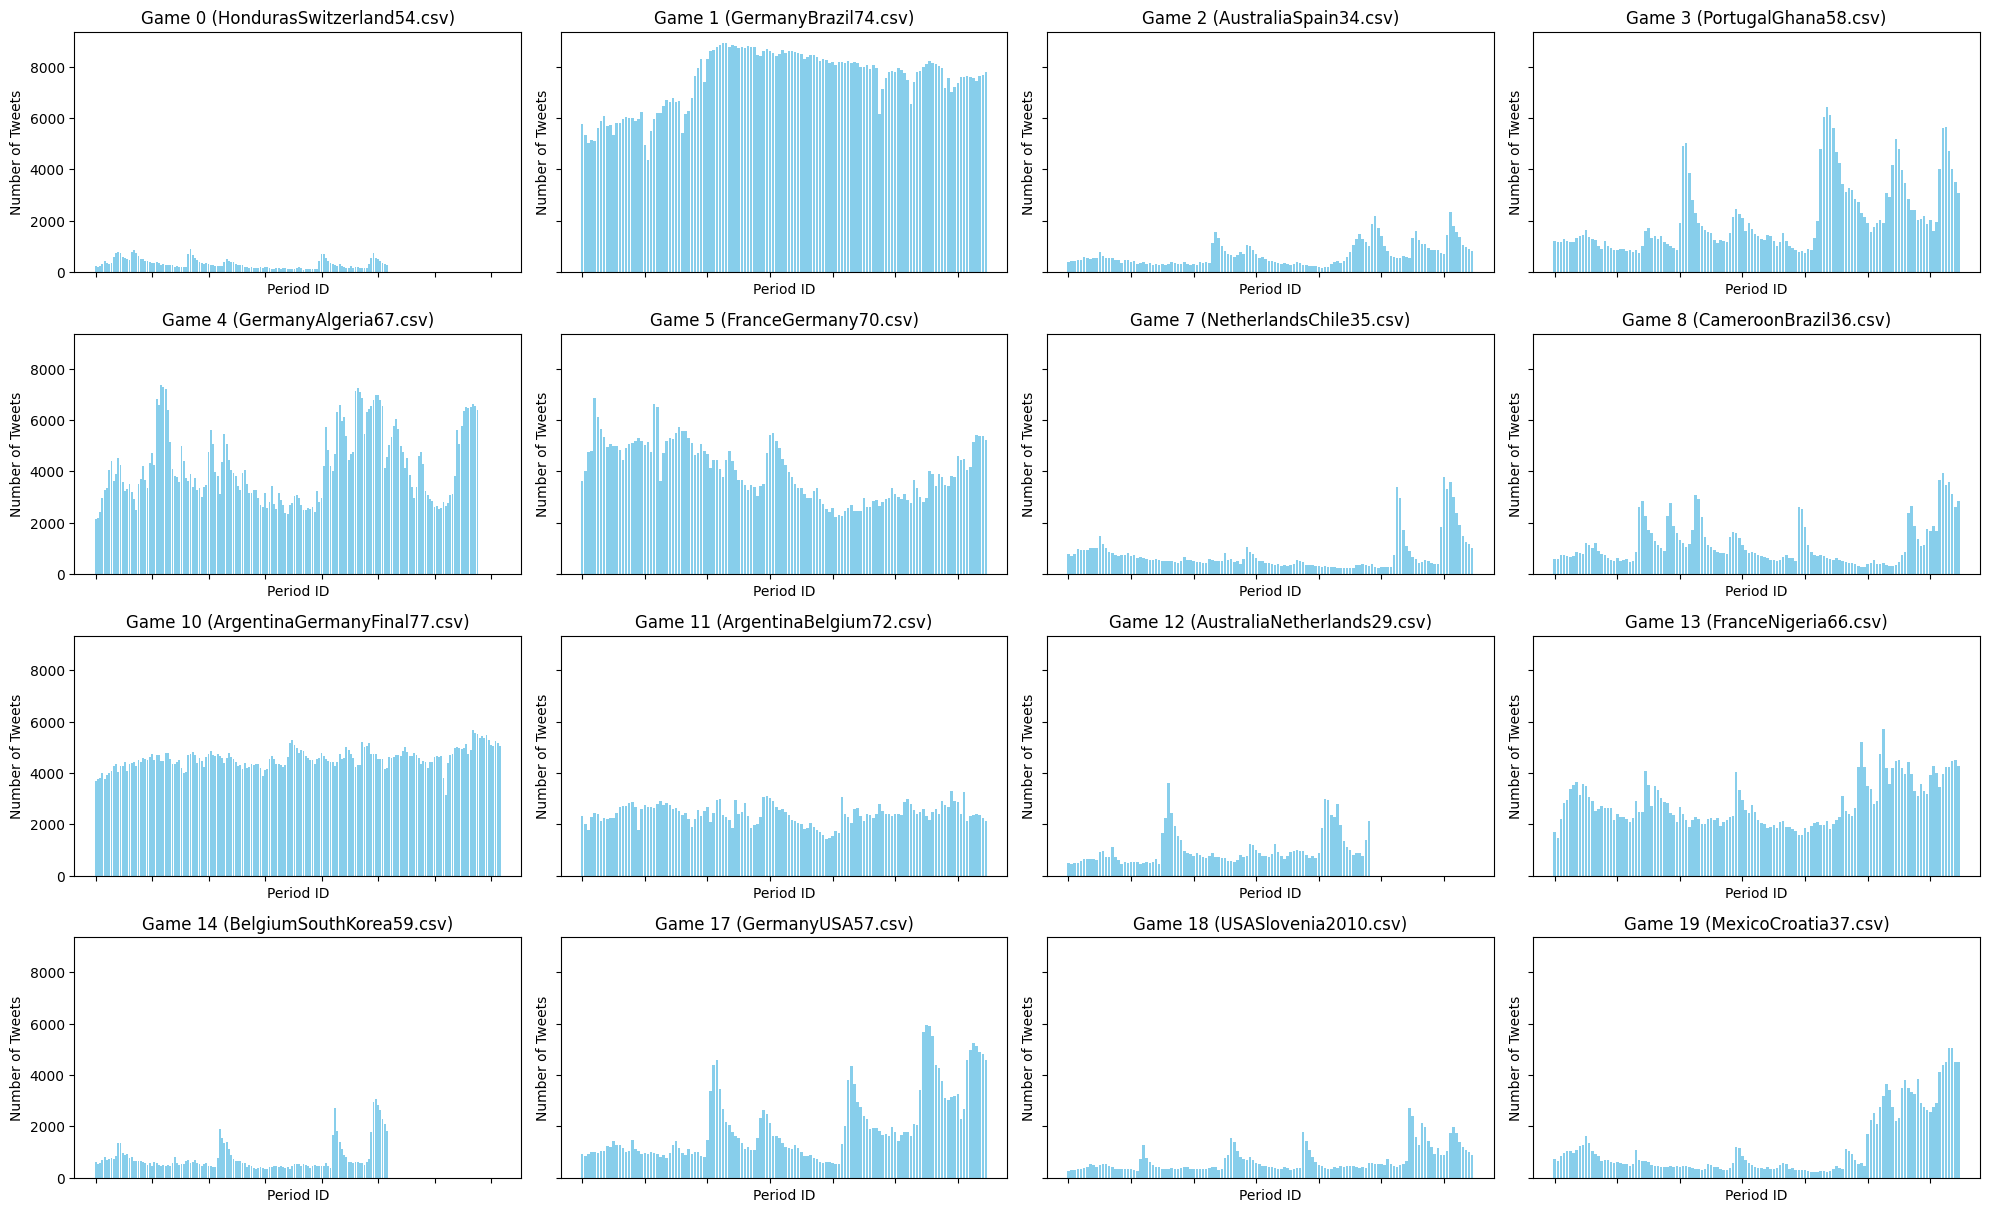

In [4]:
tweet_counts = df_train.groupby(['MatchID', 'PeriodID']).size().reset_index(name='TweetCount')
match_ids = tweet_counts['MatchID'].unique()
rows, cols = 4, 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex="col", sharey=True)
axes = axes.flatten()

for ax, match_id in zip(axes, match_ids):
    match_data = tweet_counts[tweet_counts['MatchID'] == match_id]
    file_name = matchid_to_filename.get(match_id, "Unknown")
    ax.bar(match_data['PeriodID'], match_data['TweetCount'], color='skyblue')
    ax.set_title(f'Game {match_id} ({file_name})')
    ax.set_xlabel('Period ID')
    ax.set_ylabel('Number of Tweets')

plt.tight_layout()
plt.show()

In [5]:
print(f"Total number of periods in the train set: {len(df_train['ID'].unique())}")
print(f"Max number of periods in a game in the train set: {len(df_train['PeriodID'].unique())}")

Total number of periods in the train set: 2137
Max number of periods in a game in the train set: 180


In [ ]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 257
  Average length: 27.06
  50th percentile length: 26.00
  75th percentile length: 37.00
  90th percentile length: 43.00
  95th percentile length: 47.00
  99th percentile length: 53.00


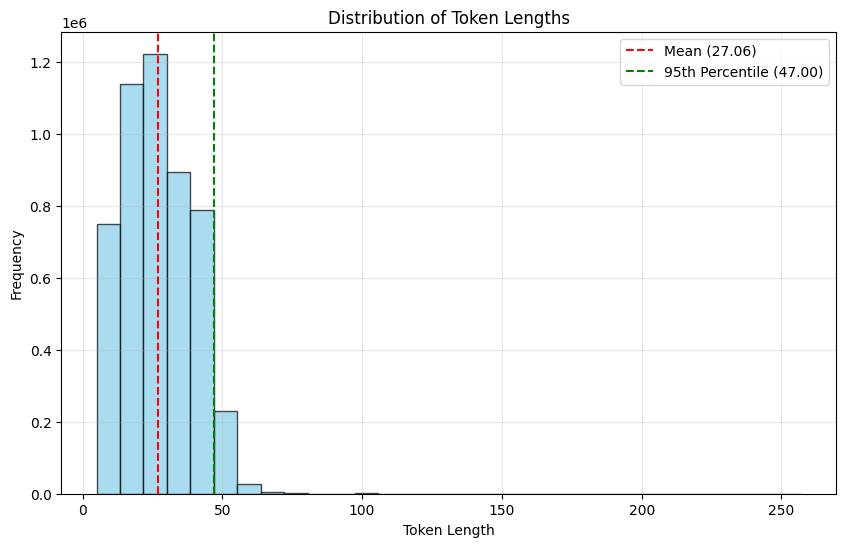

In [5]:
get_length_info(series=df_train["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

Let's choose 50 as our max length (checked also on test set below)

In [7]:
tokens = tokenizer(df_train["Tweet"].to_list(), max_length=50, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [ ]:
torch.save((tokens['input_ids'], tokens['attention_mask']), "tokens/bertweet.pt")

In [3]:
# input_ids, attention_masks = torch.load("tokens/bertweet.pt")

C:\Users\sandr\AppData\Local\Temp\ipykernel_2288\671276624.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_ids, attention_masks = torch.load("tokens/bertweet.pt")


In [10]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'])
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [11]:
final_cls_embeddings = get_cls_embeddings(model, dataloader, device)
assert final_cls_embeddings.shape == (df_train.shape[0], 768)

100%|██████████| 158002/158002 [4:57:54<00:00,  8.84it/s]  


Done!


In [12]:
df_train['cls'] = list(final_cls_embeddings.numpy())

In [ ]:
aggregated_embeddings, merged_df = process_and_merge_embeddings(
    df=df_train,
    cls_column='cls',
    id_column='ID',
    event_column='EventType',
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_embeddings_with_labels.pkl"
)

Saving merged DataFrame as pkl in aggregated_embeddings_with_labels.pkl
Saved!


In [14]:
merged_df

ID                               aggregated_embedding  EventType
0       0_0  [0.038894046, 0.2056955, 0.1732219, -0.0507800...          0
1       0_1  [0.049072143, 0.20504853, 0.16913632, -0.04101...          0
2      0_10  [-0.010199165, 0.19084008, 0.142129, -0.027013...          1
3     0_100  [0.1076907, 0.18990463, 0.13662358, -0.0059914...          1
4     0_101  [0.110753596, 0.21662608, 0.14855266, -0.02414...          1
...     ...                                                ...        ...
2132   8_95  [-0.12547426, 0.10333069, 0.012717849, 0.00890...          0
2133   8_96  [-0.13536794, 0.08814793, 0.013134736, -0.0146...          1
2134   8_97  [-0.13311367, 0.09247862, 0.016269028, 0.00072...          1
2135   8_98  [-0.12481897, 0.07730664, 0.014376387, 0.00727...          0
2136   8_99  [-0.13261126, 0.08881129, 0.017069561, -0.0076...          1

[2137 rows x 3 columns]

The vectors are already normalized.

## Test Set

We repeat the same.

In [6]:
li_test = []
matchid_to_filename_test = {}

for filename in os.listdir("data/eval_tweets"):
    df_temp = pd.read_csv(f"data/eval_tweets/{filename}")
    li_test.append(df_temp)
    unique_match_ids_val = df_temp['MatchID'].unique()
    for match_id in unique_match_ids_val:
        matchid_to_filename_test[match_id] = filename

df_test = pd.concat(li_test, ignore_index=True)

In [37]:
df_test

ID  MatchID  PeriodID      Timestamp  \
0           6_0        6         0  1403376600000   
1           6_0        6         0  1403376600000   
2           6_0        6         0  1403376600000   
3           6_0        6         0  1403376600000   
4           6_0        6         0  1403376600000   
...         ...      ...       ...            ...   
1072923  15_125       15       125  1404064800000   
1072924  15_125       15       125  1404064800000   
1072925  15_125       15       125  1404064800000   
1072926  15_125       15       125  1404064800000   
1072927  15_125       15       125  1404064800000   

                                                     Tweet  
0           I Finally get to see Germany play\n#GER   🇩🇪⚽🏆  
1        RT @Wor1dCup2014: If Any of the Boateng Brothe...  
2        Fascinated for this #GERvsGHA match. This will...  
3                                : #GER and #GHA in a few.  
4        BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...  
...                                                    ...  
1072923  Dutch deserve to be in last 8.Keep their nerve...  
1072924  RT @GeniusFootball: RETWEET if you think #MEX ...  
1072925  Hold your head high Mexico, played beautifully...  
1072926  RT @TheWorIdCup: Mexico fans right now... http...  
1072927  Go @FEDEFUTBOL_CR! #WorldCup Who are you suppo...  

[1072928 rows x 5 columns]

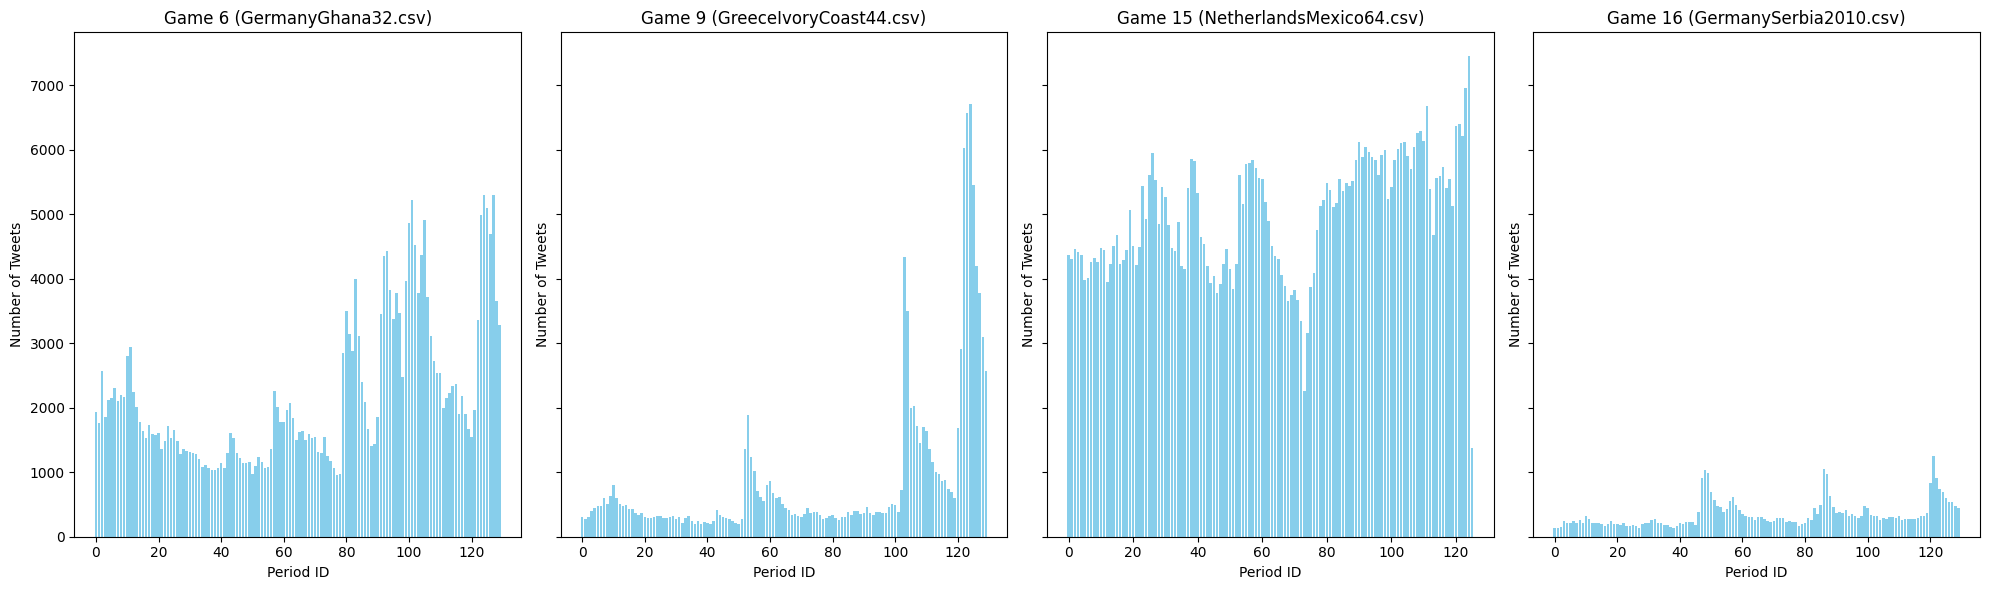

In [38]:
tweet_counts = df_test.groupby(['MatchID', 'PeriodID']).size().reset_index(name='TweetCount')
match_ids = tweet_counts['MatchID'].unique()
rows, cols = 1, 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 6), sharex="col", sharey=True)
axes = axes.flatten()

for ax, match_id in zip(axes, match_ids):
    match_data = tweet_counts[tweet_counts['MatchID'] == match_id]
    file_name = matchid_to_filename_test.get(match_id, "Unknown")
    ax.bar(match_data['PeriodID'], match_data['TweetCount'], color='skyblue')
    ax.set_title(f'Game {match_id} ({file_name})')
    ax.set_xlabel('Period ID')
    ax.set_ylabel('Number of Tweets')

plt.tight_layout()
plt.show()

In [39]:
print(f"Total number of periods in the train set: {len(df_test['ID'].unique())}")
print(f"Max number of periods in a game in the train set: {len(df_test['PeriodID'].unique())}")

Total number of periods in the train set: 516
Max number of periods in a game in the train set: 130


In [7]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 257
  Average length: 26.93
  50th percentile length: 26.00
  75th percentile length: 36.00
  90th percentile length: 43.00
  95th percentile length: 46.00
  99th percentile length: 54.00


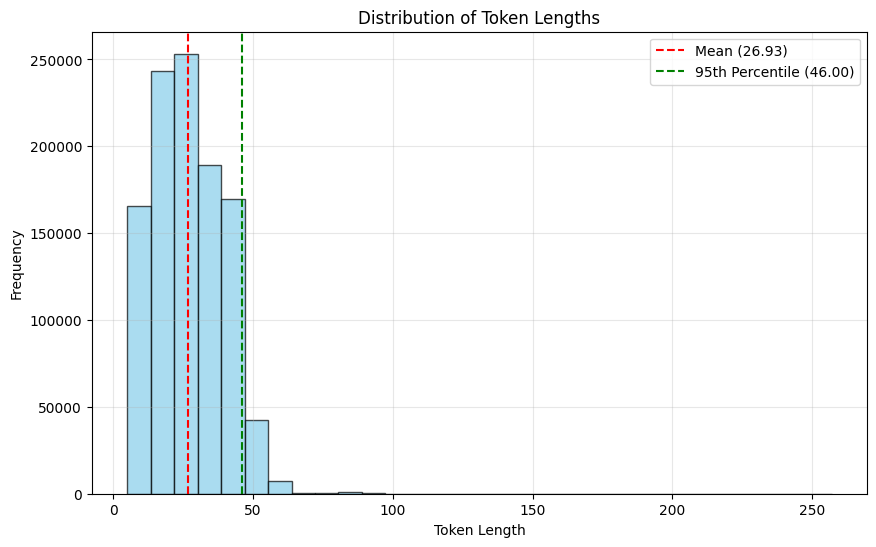

In [8]:
get_length_info(series=df_test["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

In [41]:
tokens_test = tokenizer(df_test["Tweet"].to_list(), max_length=50, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [ ]:
torch.save((tokens_test['input_ids'], tokens_test['attention_mask']), "tokens/bertweet_test.pt")

In [ ]:
# input_ids_test, attention_masks_test = torch.load("tokens/bertweet_test.pt")

In [44]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset_test = TensorDataset(tokens_test['input_ids'], tokens_test['attention_mask'])
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [45]:
final_cls_embeddings_test = get_cls_embeddings(model, dataloader_test, device)
assert final_cls_embeddings_test.shape == (df_test.shape[0], 768)

100%|██████████| 33529/33529 [1:03:17<00:00,  8.83it/s]


Done!


In [46]:
df_test['cls'] = list(final_cls_embeddings_test.numpy())

In [48]:
df_test

ID  MatchID  PeriodID      Timestamp  \
0           6_0        6         0  1403376600000   
1           6_0        6         0  1403376600000   
2           6_0        6         0  1403376600000   
3           6_0        6         0  1403376600000   
4           6_0        6         0  1403376600000   
...         ...      ...       ...            ...   
1072923  15_125       15       125  1404064800000   
1072924  15_125       15       125  1404064800000   
1072925  15_125       15       125  1404064800000   
1072926  15_125       15       125  1404064800000   
1072927  15_125       15       125  1404064800000   

                                                     Tweet  \
0           I Finally get to see Germany play\n#GER   🇩🇪⚽🏆   
1        RT @Wor1dCup2014: If Any of the Boateng Brothe...   
2        Fascinated for this #GERvsGHA match. This will...   
3                                : #GER and #GHA in a few.   
4        BOATENG GRUDGE MATCH: 21/2 for Jermaine to sco...   
...                                                    ...   
1072923  Dutch deserve to be in last 8.Keep their nerve...   
1072924  RT @GeniusFootball: RETWEET if you think #MEX ...   
1072925  Hold your head high Mexico, played beautifully...   
1072926  RT @TheWorIdCup: Mexico fans right now... http...   
1072927  Go @FEDEFUTBOL_CR! #WorldCup Who are you suppo...   

                                                       cls  
0        [0.077867225, 0.09731847, 0.059819218, -0.1415...  
1        [-0.063964926, 0.14290993, 0.0746815, -0.16638...  
2        [0.24081214, 0.13553065, 0.030091574, -0.20579...  
3        [0.26232398, 0.018381672, -0.0555337, -0.11693...  
4        [0.10413483, 0.13103765, 0.013799746, 0.014316...  
...                                                    ...  
1072923  [0.06866108, 0.15437774, 0.2838874, -0.1459453...  
1072924  [-0.025768155, 0.14188139, 0.12810758, -0.0807...  
1072925  [-0.021281535, 0.27584612, 0.21054737, -0.0213...  
1072926  [-0.16251707, 0.20360164, 0.09227639, -0.07586...  
1072927  [0.10014714, 0.1601145, 0.010888131, -0.102419...  

[1072928 rows x 6 columns]

In [ ]:
aggregated_embeddings_test, merged_df_test = process_and_merge_embeddings(
    df=df_test,
    cls_column='cls',
    id_column='ID',
    event_column="MatchID", # just put as a placeholder
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_embeddings_with_labels_test.pkl"
)

Saving merged DataFrame as pkl in aggregated_embeddings_with_labels_test.pkl
Saved!


In [51]:
merged_df_test

ID                               aggregated_embedding  MatchID
0      15_0  [-0.005626861, 0.17002444, 0.1560707, -0.07122...       15
1      15_1  [-0.012398133, 0.16987626, 0.15416442, -0.0715...       15
2     15_10  [-0.0063685165, 0.17705764, 0.14571677, -0.061...       15
3    15_100  [-0.028167112, 0.21267831, 0.11889246, -0.0327...       15
4    15_101  [-0.021408508, 0.20869574, 0.12005638, -0.0342...       15
..      ...                                                ...      ...
511    9_95  [-0.06389925, 0.15774356, 0.10894526, -0.06712...        9
512    9_96  [-0.06254904, 0.16254315, 0.10645582, -0.07547...        9
513    9_97  [-0.06544371, 0.15834767, 0.1077392, -0.078381...        9
514    9_98  [-0.061433755, 0.15302086, 0.0968332, -0.06357...        9
515    9_99  [-0.061874326, 0.16272496, 0.10401767, -0.0725...        9

[516 rows x 3 columns]

## Data Visualization

Let's visualize our embeddings.

In [72]:
X = np.vstack(merged_df["aggregated_embedding"].values)
y = merged_df["EventType"].values

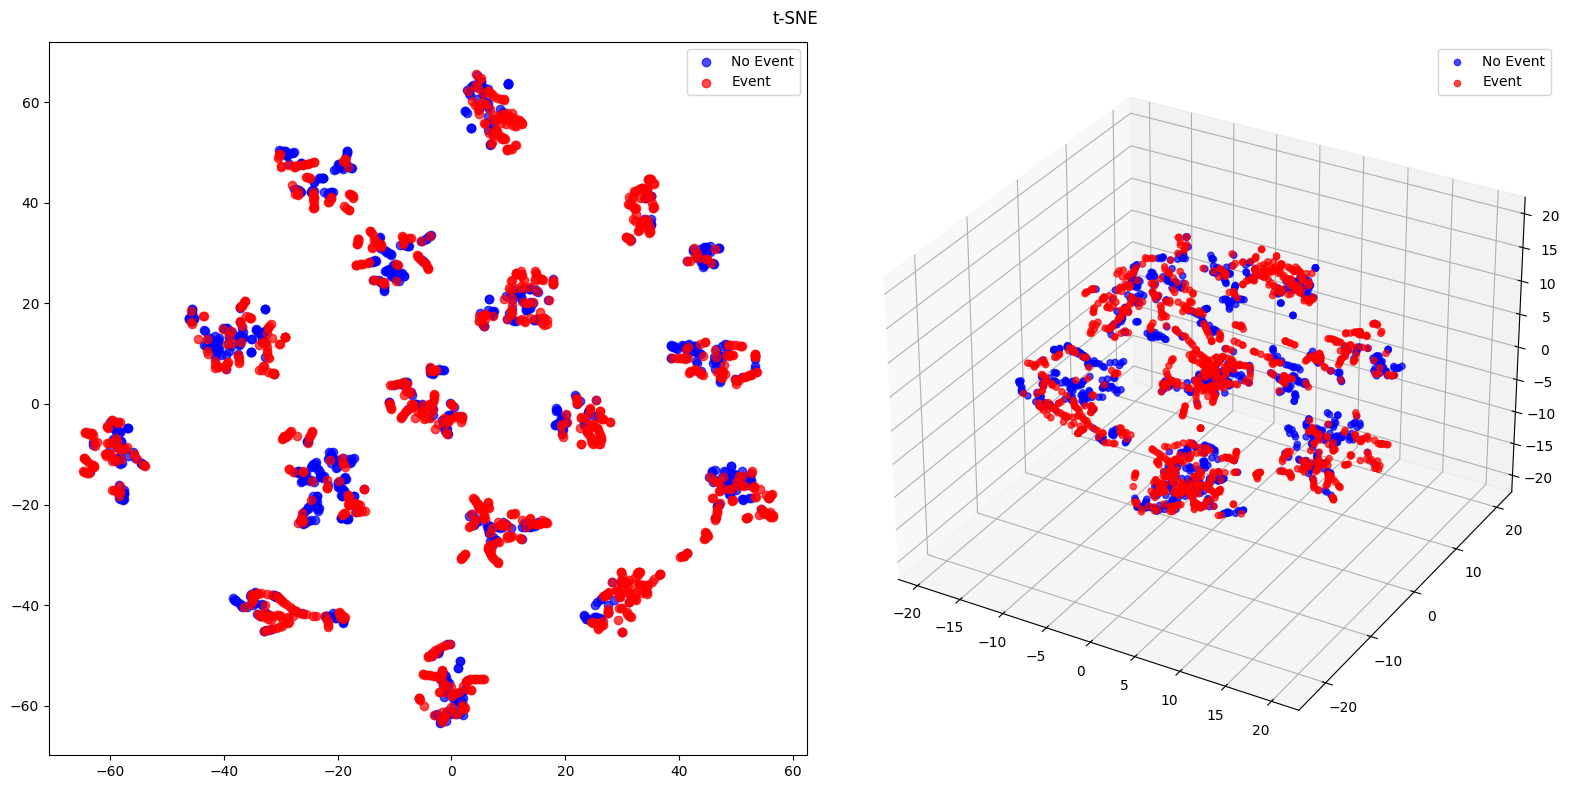

In [73]:
tsne2d = TSNE(n_components=2, random_state=seed)
reduced_embeddings2d = tsne2d.fit_transform(X)
tsne3d = TSNE(n_components=3, random_state=seed)
reduced_embeddings3d = tsne3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("t-SNE")
plt.tight_layout()
plt.show()

c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


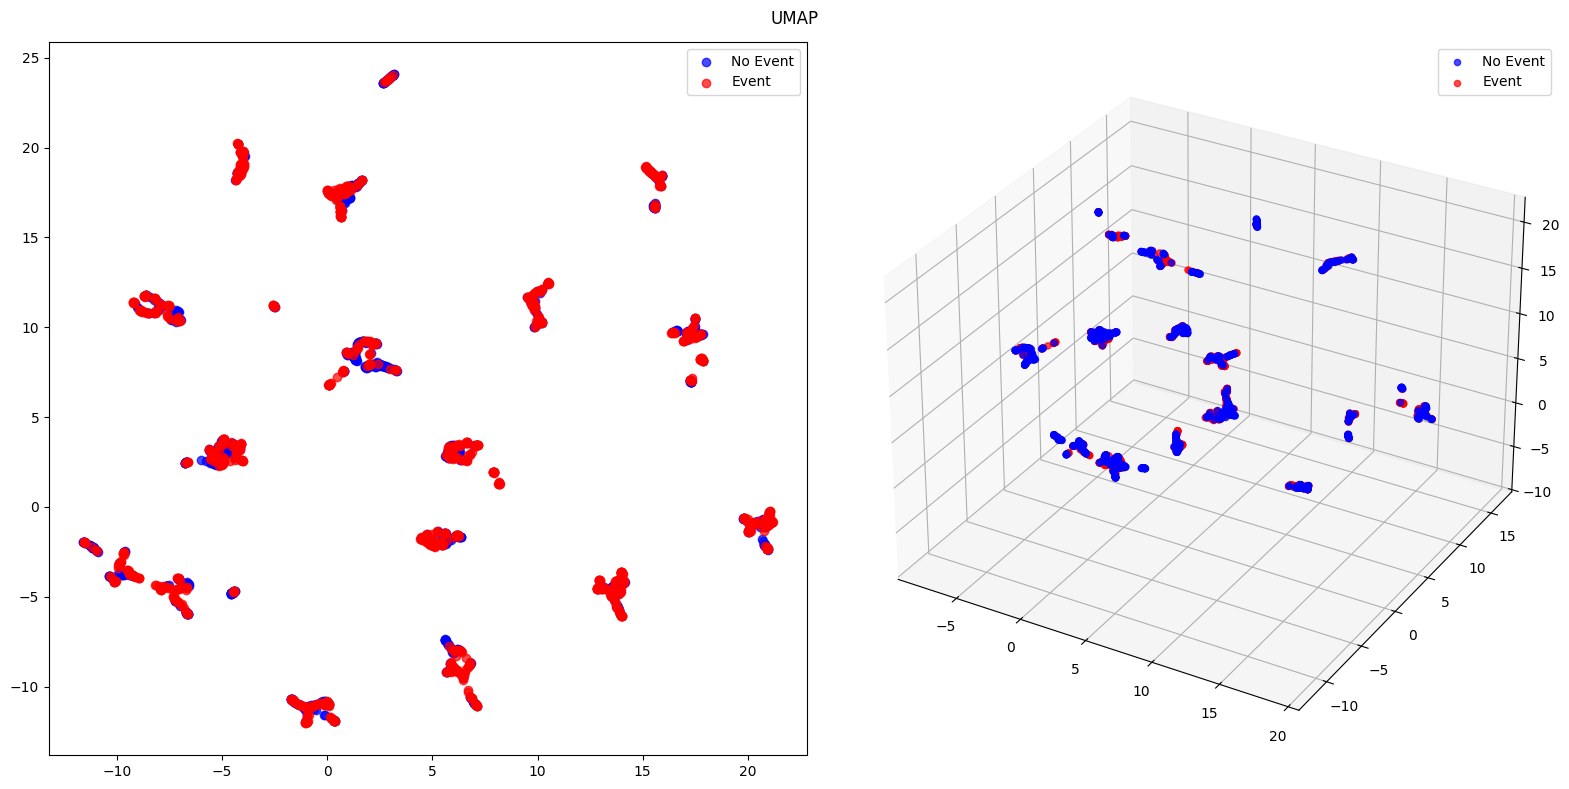

In [76]:
umap2d = umap.UMAP(n_components=2, random_state=seed)
reduced_embeddings2d = umap2d.fit_transform(X)
umap3d = umap.UMAP(n_components=3, random_state=seed)
reduced_embeddings3d = umap3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("UMAP")
plt.tight_layout()
plt.show()

Each game is clustered. The 2D and 3D plots are too low-dimensional to efficiently portray the separation between the positive and negative class. This is a suggestion for improving preprocessing to better distinguish the two classes, e.g. remove bad tweets (random, retweets), change embedding, constrative learning, feature engineering, etc.

# Preprocessing

Here we try to clean the data.

## Training Set

In [2]:
li_train = []
matchid_to_filename = {}

for filename in tqdm(os.listdir("data/train_tweets"), desc="Processing Files"):
    df_temp = pd.read_csv(f"data/train_tweets/{filename}")
    df_temp = clean_tweets(df_temp, column_name="Tweet", replace_teams=True, remove_one_word_tweets=False)
    li_train.append(df_temp)
    unique_match_ids = df_temp['MatchID'].unique()
    for match_id in unique_match_ids:
        matchid_to_filename[match_id] = filename

df_train = pd.concat(li_train, ignore_index=True)

Processing Files: 100%|██████████| 16/16 [13:05<00:00, 49.11s/it]


In [3]:
df_train

ID  MatchID  PeriodID  EventType      Timestamp  \
0          11_0       11         0          0  1404575400000   
1          11_0       11         0          0  1404575400000   
2          11_0       11         0          0  1404575400000   
3          11_0       11         0          0  1404575400000   
4          11_0       11         0          0  1404575400000   
...         ...      ...       ...        ...            ...   
2371693  18_129       18       129          0  1276876799000   
2371694  18_129       18       129          0  1276876799000   
2371695  18_129       18       129          0  1276876799000   
2371696  18_129       18       129          0  1276876799000   
2371697  18_129       18       129          0  1276876799000   

                                                     Tweet  
0        @elijahman_ time to focus on <team_2> winning ...  
1        i just hope <team_1> lose. would be fun to see...  
2        watch <team_1> vs <team_2> 5th july 2014 live ...  
3                     @jrmun0z why dont you like <team_1>.  
4        even though i hate <team_2> for beating the us...  
...                                                    ...  
2371693  ok, so <team> has to tie and not score more th...  
2371694  but that was a real soccer match after so many...  
2371695                 @heykolls no! <team_1> worldcup :)  
2371696  woah. that was an awesome game of soccer just ...  
2371697       ugh!!! should've been 3-2 <team_1>! worldcup  

[2371698 rows x 6 columns]

In [4]:
df_train["EventType"].value_counts(normalize=True)

EventType
1    0.57349
0    0.42651
Name: proportion, dtype: float64

In [5]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 257
  Average length: 25.20
  50th percentile length: 23.00
  75th percentile length: 32.00
  90th percentile length: 40.00
  95th percentile length: 45.00
  99th percentile length: 52.00


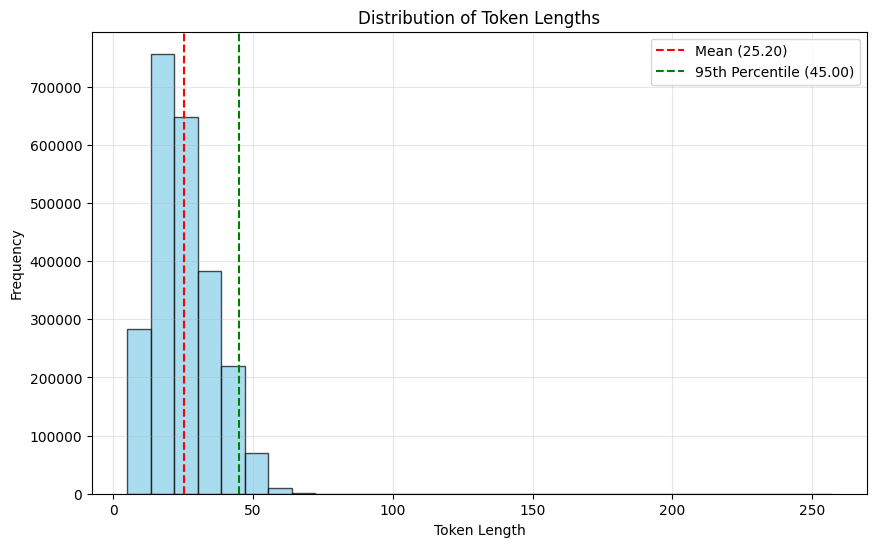

In [6]:
get_length_info(series=df_train["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

In [7]:
tokens = tokenizer(df_train["Tweet"].to_list(), max_length=50, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [8]:
torch.save((tokens['input_ids'], tokens['attention_mask']), "tokens/bertweet_processed2_no_teams.pt")

In [9]:
# input_ids, attention_masks = torch.load("tokens/bertweet_processed2_no_teams.pt")

In [10]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'])
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [11]:
final_cls_embeddings = get_cls_embeddings(model, dataloader, device)
assert final_cls_embeddings.shape == (df_train.shape[0], 768)

100%|██████████| 74116/74116 [2:18:22<00:00,  8.93it/s]  


Done!


In [12]:
df_train['cls'] = list(final_cls_embeddings.numpy())

In [14]:
# csv.write_csv(pa.Table.from_pandas(df_train), "df_processed2_no_teams_embedding_per_tweet.csv")

In [15]:
aggregated_embeddings, merged_df = process_and_merge_embeddings(
    df=df_train,
    cls_column='cls',
    id_column='ID',
    event_column='EventType',
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_processed2_no_teams_embeddings_with_labels.pkl"
)

Saving merged DataFrame as pkl in processed_data/aggregated_processed2_no_teams_embeddings_with_labels.pkl
Saved!


In [16]:
merged_df

ID                               aggregated_embedding  EventType
0       0_0  [0.113946006, 0.25405857, 0.16819511, -0.08124...          0
1       0_1  [0.12009395, 0.26731277, 0.16090168, -0.075128...          0
2      0_10  [0.080117695, 0.2617985, 0.16096576, -0.055389...          1
3     0_100  [0.090920724, 0.26141953, 0.14952163, -0.04513...          1
4     0_101  [0.07735666, 0.26382214, 0.15831298, -0.050265...          1
...     ...                                                ...        ...
2132   8_95  [0.04423167, 0.25001833, 0.124842525, -0.04715...          0
2133   8_96  [0.045176312, 0.2502851, 0.12884046, -0.059398...          1
2134   8_97  [0.060056362, 0.24012491, 0.13202657, -0.04622...          1
2135   8_98  [0.03901225, 0.24715461, 0.11884401, -0.045139...          0
2136   8_99  [0.045839842, 0.25209633, 0.13479443, -0.04684...          1

[2137 rows x 3 columns]

## Test Set

In [17]:
li_test = []
matchid_to_filename_test = {}

for filename in tqdm(os.listdir("data/eval_tweets"), desc="Processing Files"):
    df_temp = pd.read_csv(f"data/eval_tweets/{filename}")
    df_temp = clean_tweets(df_temp, column_name="Tweet", replace_teams=True, remove_one_word_tweets=True)
    li_test.append(df_temp)
    unique_match_ids_val = df_temp['MatchID'].unique()
    for match_id in unique_match_ids_val:
        matchid_to_filename_test[match_id] = filename

df_test = pd.concat(li_test, ignore_index=True)

Processing Files: 100%|██████████| 4/4 [02:48<00:00, 42.24s/it]


In [18]:
df_test

ID  MatchID  PeriodID      Timestamp  \
0          6_0        6         0  1403376600000   
1          6_0        6         0  1403376600000   
2          6_0        6         0  1403376600000   
3          6_0        6         0  1403376600000   
4          6_0        6         0  1403376600000   
...        ...      ...       ...            ...   
522401  15_125       15       125  1404064800000   
522402  15_125       15       125  1404064800000   
522403  15_125       15       125  1404064800000   
522404  15_125       15       125  1404064800000   
522405  15_125       15       125  1404064800000   

                                                    Tweet  
0              i finally get to see <team_1> playger 🇩🇪⚽🏆  
1       fascinated for this gervsgha match. this will ...  
2                       : <team_1> and <team_2> in a few.  
3       boateng grudge match: 21/2 for jermaine to sco...  
4                  our players jooo <team_1> worldcup2014  
...                                                   ...  
522401  <team_1> what a team ! ochoa world cup goal ke...  
522402                 harsh on <team_1> though! <team_1>  
522403  dutch deserve to be in last 8.keep their nerve...  
522404  hold your head high <team_1>, played beautiful...  
522405  go @fedefutbol_cr! worldcup who are you suppor...  

[522406 rows x 5 columns]

In [19]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModel.from_pretrained("vinai/bertweet-base")
model = model.to(device)

Token Length Statistics:
  Max length: 255
  Average length: 24.63
  50th percentile length: 23.00
  75th percentile length: 31.00
  90th percentile length: 40.00
  95th percentile length: 44.00
  99th percentile length: 53.00


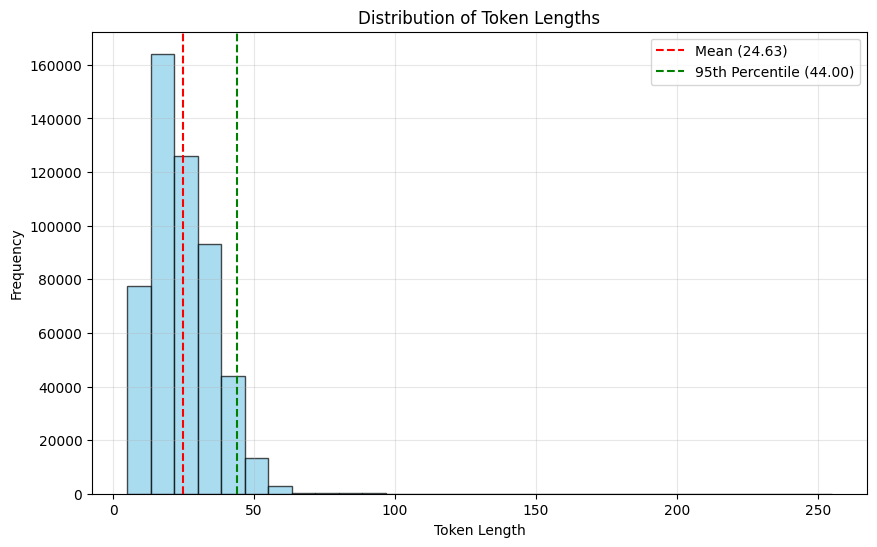

In [20]:
get_length_info(series=df_test["Tweet"], tokenizer=tokenizer, percentiles=[50, 75, 90, 95, 99], plot=True, verbose=True)

In [21]:
tokens_test = tokenizer(df_test["Tweet"].to_list(), max_length=50, padding="max_length", truncation=True, add_special_tokens=True, return_tensors="pt")

In [22]:
torch.save((tokens_test['input_ids'], tokens_test['attention_mask']), "tokens/bertweet_processed2_no_teams_test.pt")

In [23]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

dataset_test = TensorDataset(tokens_test['input_ids'], tokens_test['attention_mask'])
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [24]:
final_cls_embeddings_test = get_cls_embeddings(model, dataloader_test, device)
assert final_cls_embeddings_test.shape == (df_test.shape[0], 768)

100%|██████████| 16326/16326 [29:44<00:00,  9.15it/s]


Done!


In [25]:
df_test['cls'] = list(final_cls_embeddings_test.numpy())

In [26]:
# csv.write_csv(pa.Table.from_pandas(df_test), "df_processed2_no_teams_embedding_per_tweet_test.csv")

In [27]:
aggregated_embeddings_test, merged_df_test = process_and_merge_embeddings(
    df=df_test,
    cls_column='cls',
    id_column='ID',
    event_column="MatchID", # just put as a placeholder
    aggregation_func=aggregate_embeddings,
    criterion="mean",  
    output_format='pkl', 
    output_path="processed_data/aggregated_processed2_no_teams_embeddings_with_labels_test.pkl"
)

Saving merged DataFrame as pkl in processed_data/aggregated_processed2_no_teams_embeddings_with_labels_test.pkl
Saved!


In [28]:
merged_df_test

ID                               aggregated_embedding  MatchID
0      15_0  [0.035253562, 0.23655745, 0.16431181, -0.07380...       15
1      15_1  [0.03411878, 0.23766541, 0.1651518, -0.0725717...       15
2     15_10  [0.03397343, 0.24619274, 0.15815593, -0.066160...       15
3    15_100  [0.032807227, 0.25758964, 0.13975443, -0.06406...       15
4    15_101  [0.022793747, 0.25055176, 0.14461406, -0.06714...       15
..      ...                                                ...      ...
511    9_95  [0.021518555, 0.23988654, 0.14205514, -0.06648...        9
512    9_96  [0.023369381, 0.2511798, 0.12941337, -0.068324...        9
513    9_97  [0.02505665, 0.24075839, 0.13532451, -0.064753...        9
514    9_98  [0.027225649, 0.23875152, 0.13362586, -0.06027...        9
515    9_99  [0.026402691, 0.25024053, 0.13575569, -0.06517...        9

[516 rows x 3 columns]

## Data Visualization

In [29]:
file_path = "processed_data/aggregated_processed2_no_teams_embeddings_with_labels.pkl"
merged_df = pd.read_pickle(file_path)
X = np.vstack(merged_df["aggregated_embedding"].values)
y = merged_df["EventType"].values

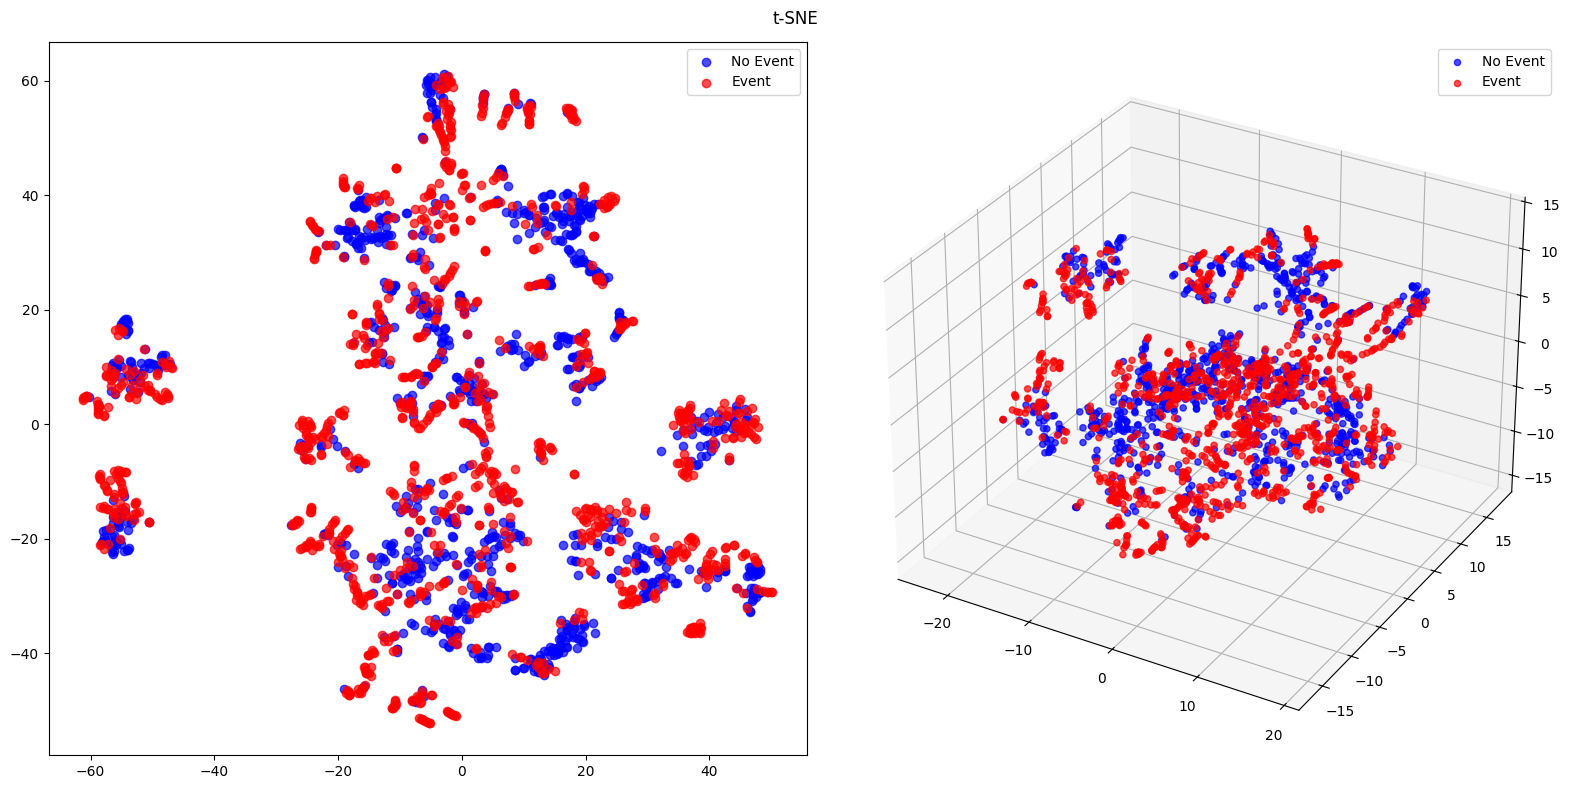

In [30]:
tsne2d = TSNE(n_components=2, random_state=seed)
reduced_embeddings2d = tsne2d.fit_transform(X)
tsne3d = TSNE(n_components=3, random_state=seed)
reduced_embeddings3d = tsne3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("t-SNE")
plt.tight_layout()
plt.show()

c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


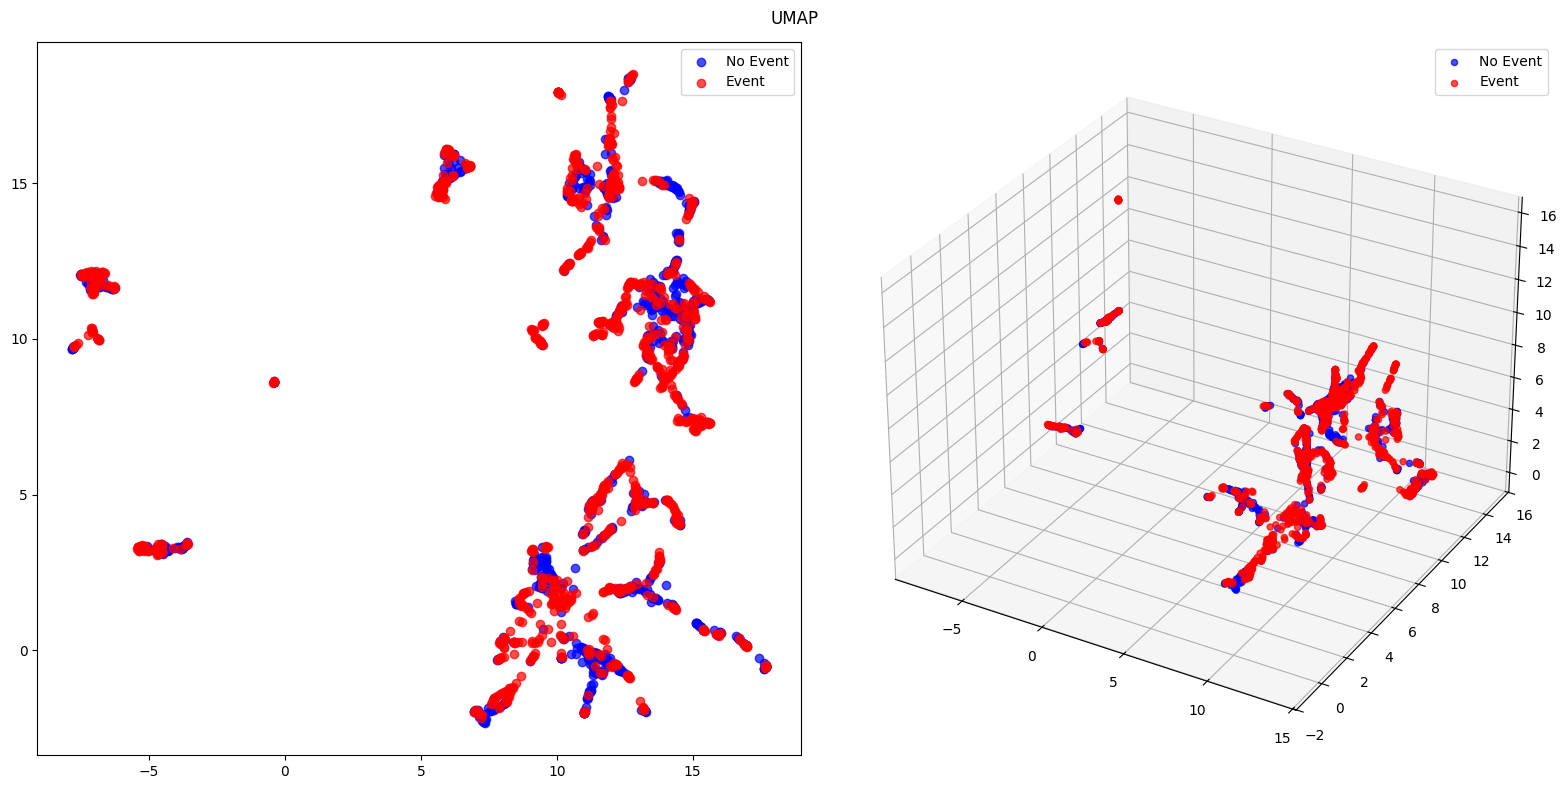

In [31]:
umap2d = umap.UMAP(n_components=2, random_state=seed)
reduced_embeddings2d = umap2d.fit_transform(X)
umap3d = umap.UMAP(n_components=3, random_state=seed)
reduced_embeddings3d = umap3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("UMAP")
plt.tight_layout()
plt.show()

Now it seems like the event and non-event periods are a bit more separable.

# Preprocessing with Similarity Aggregation

## Training Set

In [107]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity

def process_and_merge_embeddings_by_similarity(df, cls_column="cls", event_type_column="EventType", id_column="ID", output_format=None, output_path=None):
    """
    Aggregates embeddings per ID and merges the result with unique event-related data.

    Args:
        df (pd.DataFrame): The input DataFrame containing embeddings and labels.
        cls_column (str): The name of the column containing individual embeddings (e.g., 'cls').
        event_type_column (str): The name of the column containing labels (e.g., 'EventType').
        id_column (str): The name of the column used for grouping (e.g., 'ID').
        output_format (str, optional): The format to save the output ('csv' or 'pkl'). Defaults to None.
        output_path (str, optional): The path to save the output file. Required if `output_format` is specified.

    Returns:
        pd.DataFrame: A merged DataFrame containing aggregated embeddings and associated labels.
        
    Raises:
        ValueError: If `output_path` is not provided when `output_format` is specified.
        ValueError: If an invalid `output_format` is provided.
    """
    id_aggregated_embeddings = []

    # Group by ID
    id_groups = df.groupby(id_column)

    for unique_id, id_samples in id_groups:
        # Group the ID data by EventType
        event_type_groups = id_samples.groupby(event_type_column)
        event_type_aggregations = []
        total_tweets_in_id = len(id_samples)

        for event_type, event_type_samples in event_type_groups:
            # Extract embeddings for the current event type
            embeddings = np.vstack(event_type_samples[cls_column])  # (N, D)

            # Compute the reference embedding (mean)
            reference_embedding = np.mean(embeddings, axis=0)

            # Compute cosine similarities with the reference embedding
            similarities = cosine_similarity(embeddings, reference_embedding.reshape(1, -1)).flatten()

            # Normalize similarities using softmax to get attention weights
            attention_weights = torch.softmax(torch.tensor(similarities), dim=0).numpy()

            # Compute weighted aggregation for this event type
            weighted_aggregation = np.dot(attention_weights, embeddings)

            # Store the weighted aggregation with its contribution weight (based on size)
            event_type_aggregations.append((weighted_aggregation, len(embeddings)))

        # Combine weighted aggregations from all event types
        final_id_embedding = sum(
            (event_size / total_tweets_in_id) * event_embedding
            for event_embedding, event_size in event_type_aggregations
        )
        id_aggregated_embeddings.append({"ID": unique_id, "aggregated_embedding": final_id_embedding})

    # Convert to DataFrame
    aggregated_df = pd.DataFrame(id_aggregated_embeddings)

    # Merge with labels or unique event-related data
    merged_df = pd.merge(
        aggregated_df,
        df[[id_column, event_type_column]].drop_duplicates(),
        on=id_column,
        how="inner"
    )
    
    # save output if requested
    if output_format:
        if not output_path:
            raise ValueError("output_path must be specified if output_format is provided.")
        
        if output_format == 'csv':
            print(f"Saving merged DataFrame as {output_format} in {output_path}")
            merged_df.to_csv(output_path, index=False)
            print("Saved!")
        elif output_format == 'pkl':
            print(f"Saving merged DataFrame as {output_format} in {output_path}")
            merged_df.to_pickle(output_path)
            print("Saved!")
        else:
            raise ValueError("Invalid output_format. Choose 'csv' or 'pkl'.")
    
    return merged_df

In [115]:
merged_df = process_and_merge_embeddings_by_similarity(df_train,
                                                       cls_column="cls", event_type_column="EventType", id_column="ID",
                                                       output_format="pkl",
                                                       output_path="processed_data/similarity_aggregated_processed2_no_teams_embeddings_with_labels.pkl")

Saving merged DataFrame as pkl in processed_data/similarity_aggregated_processed2_no_teams_embeddings_with_labels.pkl
Saved!


In [116]:
merged_df

ID                               aggregated_embedding  EventType
0       0_0  [0.113863185, 0.25399217, 0.16831651, -0.08117...          0
1       0_1  [0.120237485, 0.2669787, 0.16120772, -0.075147...          0
2      0_10  [0.07998199, 0.26179686, 0.1610382, -0.0552430...          1
3     0_100  [0.09074174, 0.26145023, 0.14973955, -0.044975...          1
4     0_101  [0.07723929, 0.26390603, 0.15838297, -0.050099...          1
...     ...                                                ...        ...
2132   8_95  [0.0442052, 0.25004005, 0.12509423, -0.0469851...          0
2133   8_96  [0.045044363, 0.25035122, 0.1290281, -0.059350...          1
2134   8_97  [0.05991027, 0.24008104, 0.13231327, -0.046415...          1
2135   8_98  [0.03905512, 0.24726795, 0.11885731, -0.045002...          0
2136   8_99  [0.045700755, 0.25223252, 0.13476954, -0.04659...          1

[2137 rows x 3 columns]

## Data Visualization

In [109]:
X = np.vstack(merged_df["aggregated_embedding"].values)
y = merged_df["EventType"].values

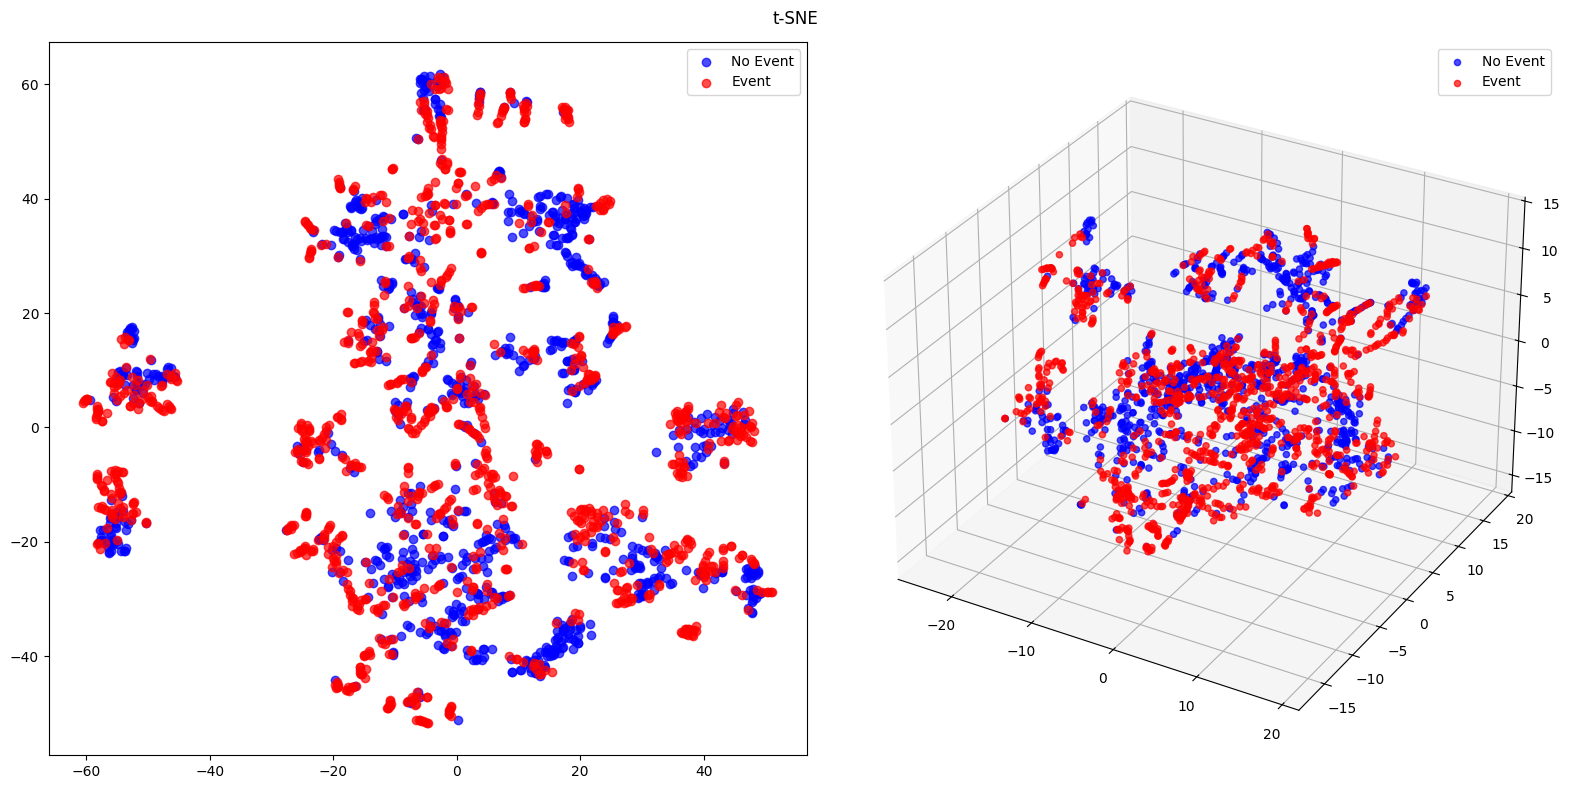

In [110]:
tsne2d = TSNE(n_components=2, random_state=seed)
reduced_embeddings2d = tsne2d.fit_transform(X)
tsne3d = TSNE(n_components=3, random_state=seed)
reduced_embeddings3d = tsne3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("t-SNE")
plt.tight_layout()
plt.show()

c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


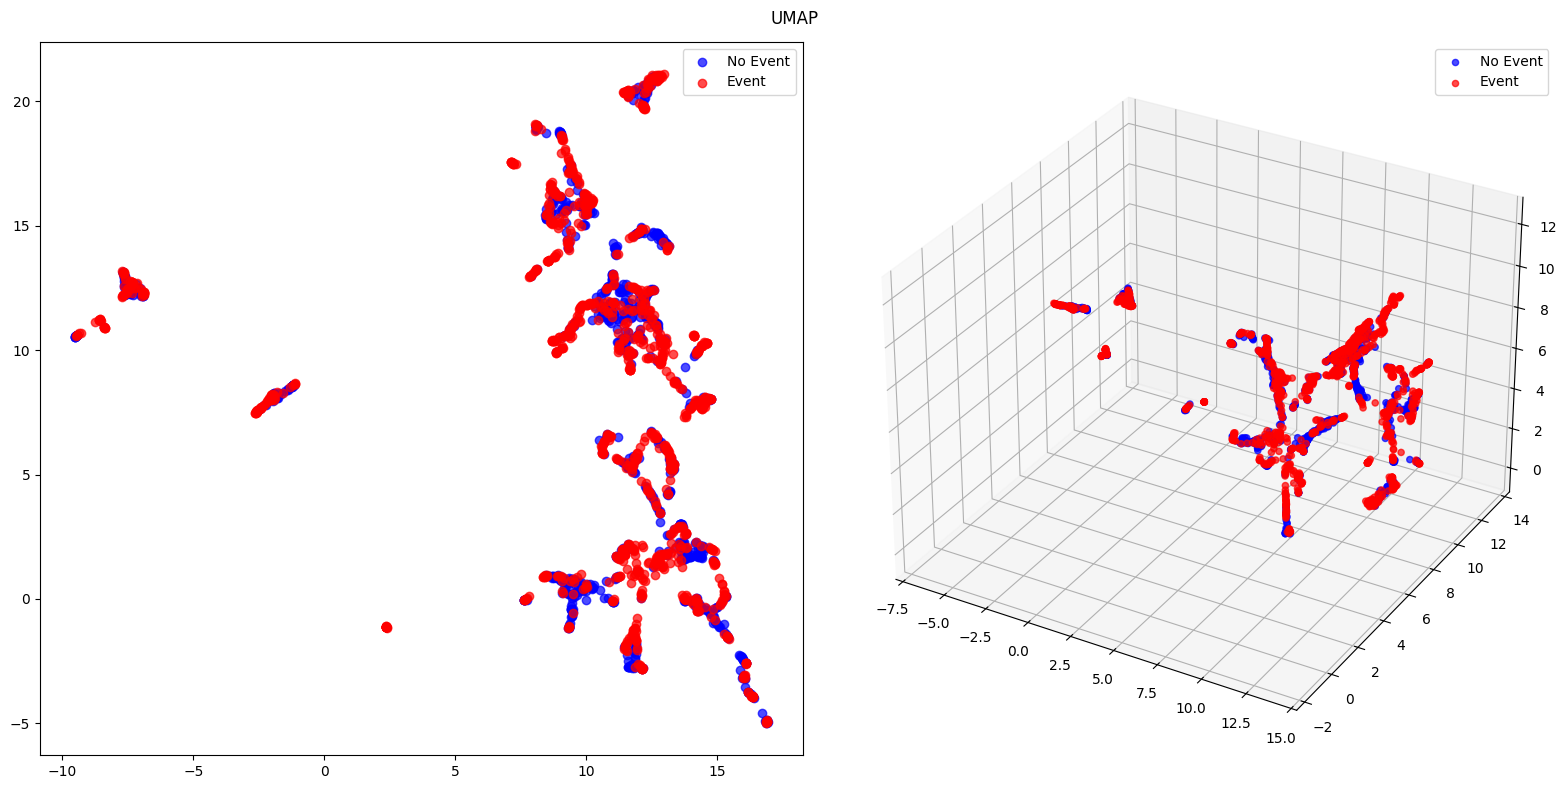

In [111]:
umap2d = umap.UMAP(n_components=2, random_state=seed)
reduced_embeddings2d = umap2d.fit_transform(X)
umap3d = umap.UMAP(n_components=3, random_state=seed)
reduced_embeddings3d = umap3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("UMAP")
plt.tight_layout()
plt.show()

## Test Set

In [119]:
merged_df_test = process_and_merge_embeddings_by_similarity(df_test,
                                                            cls_column="cls", event_type_column="MatchID", id_column="ID",
                                                            output_format="pkl",
                                                            output_path="processed_data/similarity_aggregated_processed2_no_teams_embeddings_with_labels_test.pkl")

merged_df_test

Saving merged DataFrame as pkl in processed_data/similarity_aggregated_processed2_no_teams_embeddings_with_labels_test.pkl
Saved!


ID                               aggregated_embedding  MatchID
0      15_0  [0.035216145, 0.23670512, 0.16461788, -0.07351...       15
1      15_1  [0.034069423, 0.23782559, 0.16553776, -0.07227...       15
2     15_10  [0.03389384, 0.24631235, 0.15847614, -0.065858...       15
3    15_100  [0.032782994, 0.25771907, 0.14000085, -0.06382...       15
4    15_101  [0.022839505, 0.25066984, 0.14487386, -0.06689...       15
..      ...                                                ...      ...
511    9_95  [0.021239778, 0.2399597, 0.1421722, -0.0662935...        9
512    9_96  [0.023016805, 0.2511774, 0.12957984, -0.068158...        9
513    9_97  [0.02473588, 0.2408242, 0.13554707, -0.0646261...        9
514    9_98  [0.02699592, 0.23885195, 0.13381645, -0.060118...        9
515    9_99  [0.026203532, 0.2503568, 0.1359882, -0.0650007...        9

[516 rows x 3 columns]

# Contrastive Learning Preprocessing

## Training Set

In [183]:
file_path = "processed_data/similarity_aggregated_processed2_no_teams_embeddings_with_labels.pkl"
merged_df = pd.read_pickle(file_path)

In [184]:
merged_df

ID                               aggregated_embedding  EventType
0       0_0  [0.113863185, 0.25399217, 0.16831651, -0.08117...          0
1       0_1  [0.120237485, 0.2669787, 0.16120772, -0.075147...          0
2      0_10  [0.07998199, 0.26179686, 0.1610382, -0.0552430...          1
3     0_100  [0.09074174, 0.26145023, 0.14973955, -0.044975...          1
4     0_101  [0.07723929, 0.26390603, 0.15838297, -0.050099...          1
...     ...                                                ...        ...
2132   8_95  [0.0442052, 0.25004005, 0.12509423, -0.0469851...          0
2133   8_96  [0.045044363, 0.25035122, 0.1290281, -0.059350...          1
2134   8_97  [0.05991027, 0.24008104, 0.13231327, -0.046415...          1
2135   8_98  [0.03905512, 0.24726795, 0.11885731, -0.045002...          0
2136   8_99  [0.045700755, 0.25223252, 0.13476954, -0.04659...          1

[2137 rows x 3 columns]

In [185]:
# Extract game IDs from the "ID" column
merged_df['GameID'] = merged_df['ID'].apply(lambda x: int(x.split('_')[0]))

PLAN:
- nonlinear projection head (onto 256 dimensions)
- train via supervised contrastive loss

In [186]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class EmbeddingDataset(Dataset):
    def __init__(self, df):
        self.embeddings = np.stack(df["aggregated_embedding"].values).astype(np.float32) # 2136,768
        self.labels = df["EventType"].values.astype(np.int64)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

In [187]:
import torch.nn as nn

class ProjectionHead(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=512, output_dim=256, dropout_p=0.2):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),  
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [188]:
import torch.nn.functional as F

class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, high_temperature=0.8, low_temperature=0.2, total_epochs=10, fraction_epochs=0.3):
        super(SupervisedContrastiveLoss, self).__init__()
        self.high_temperature = high_temperature
        self.low_temperature = low_temperature
        self.total_epochs = total_epochs
        self.fraction_epochs = fraction_epochs
        self.current_epoch = 0

    def set_epoch(self, epoch):
        self.current_epoch = epoch

    def get_temperature(self):
        # fraction of completed epochs
        fraction = self.current_epoch / float(self.total_epochs)

        # Suppose we hold high temperature until halfway and then
        # linearly decay to low_temperature in the second half.
        # knee_point = 0.3  # half way point
        if fraction < self.fraction_epochs:
            # Before the knee: keep temperature relatively high and stable
            return self.high_temperature
        else:
            # After the knee: linearly decay from high_temperature to low_temperature
            fraction_after_knee = (fraction - self.fraction_epochs) / (1.0 - self.fraction_epochs)
            decayed_temp = self.high_temperature - (self.high_temperature - self.low_temperature) * fraction_after_knee
            # Ensure the temperature does not drop below low_temperature
            return max(decayed_temp, self.low_temperature)

    def forward(self, embeddings, labels):
    
        # Compute pairwise similarity
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        temperature = self.get_temperature()
        similarity_matrix = torch.matmul(embeddings, embeddings.T) / temperature
        
        # Mask to identify positive pairs
        labels = labels.unsqueeze(1)  # (batch_size, 1)
        mask = torch.eq(labels, labels.T).float()  # (batch_size, batch_size)
        
        # Compute contrastive loss
        exp_similarity = torch.exp(similarity_matrix)
        positive_pairs = mask * exp_similarity
        loss = -torch.log((positive_pairs.sum(dim=1) + 1e-8) / exp_similarity.sum(dim=1))
        return loss.mean()

Testing params: LR=0.001, High Temp=0.8, Low Temp=0.2, Dropout=0.2
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:05<00:00,  9.36it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  8.72it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


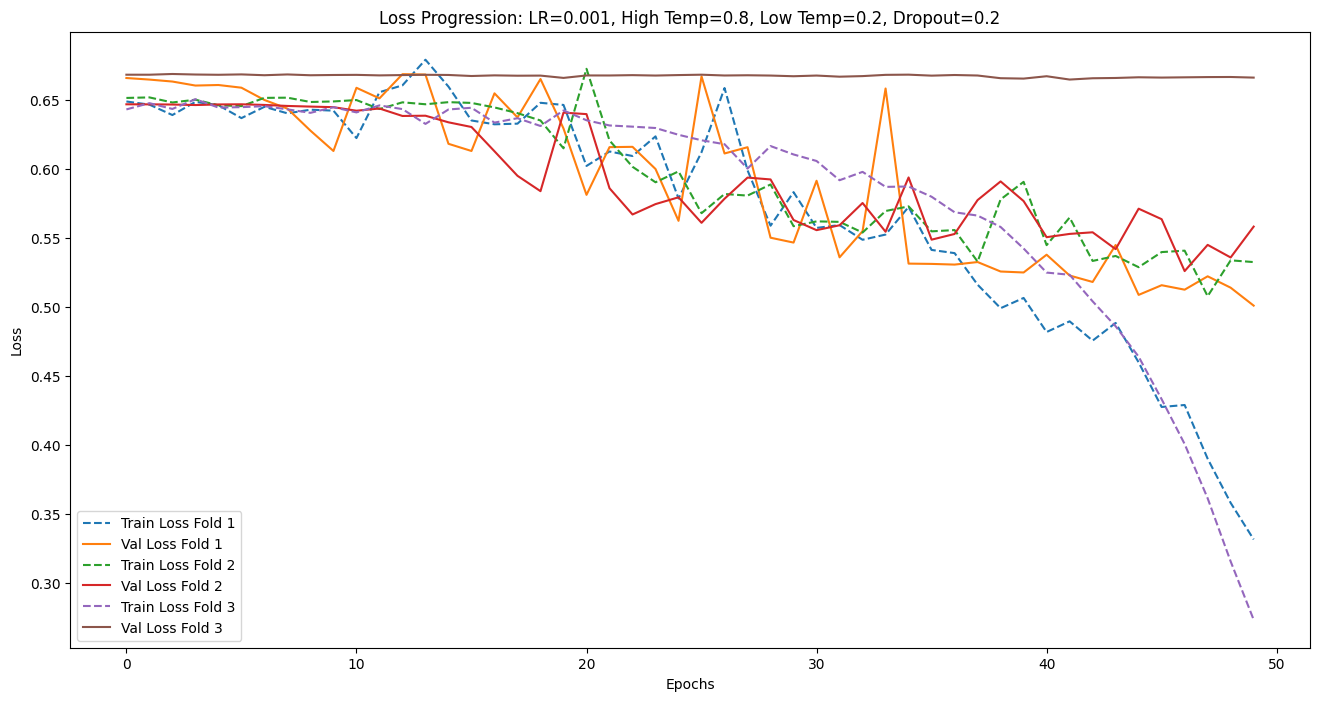

Testing params: LR=0.001, High Temp=0.8, Low Temp=0.2, Dropout=0.3
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:04<00:00, 10.31it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  8.59it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  9.51it/s]


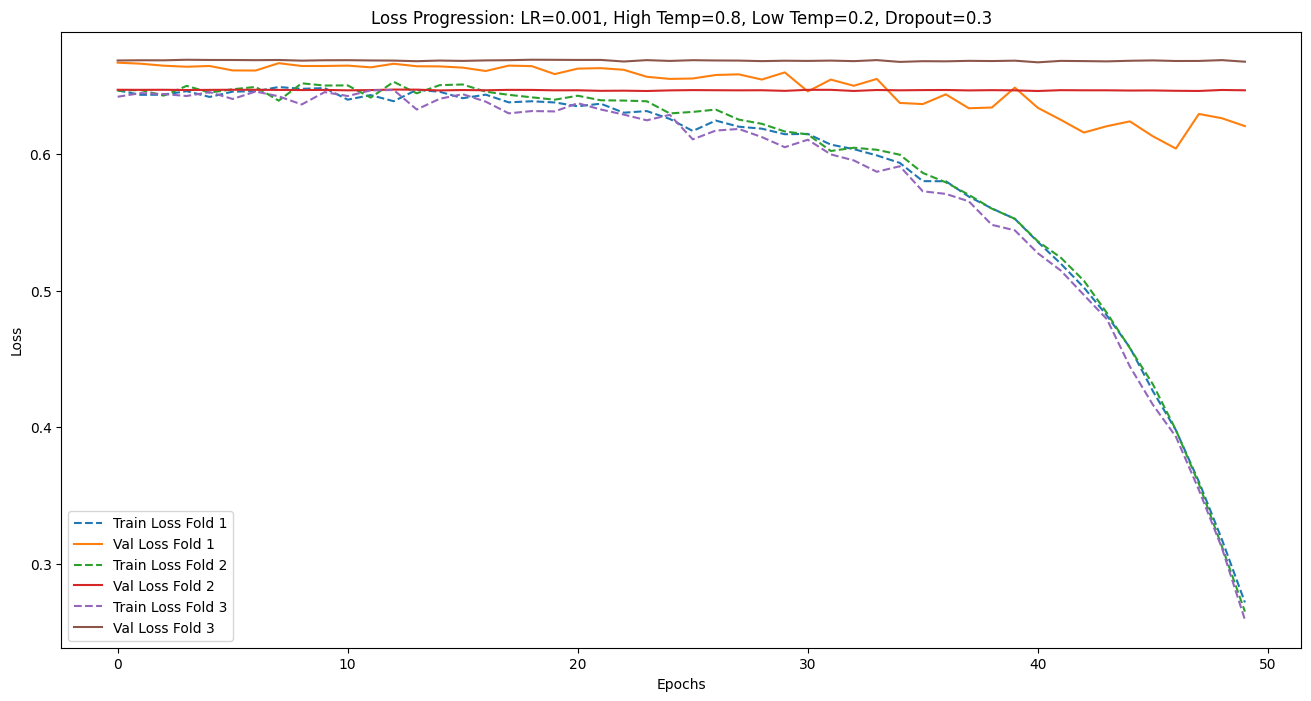

Testing params: LR=0.001, High Temp=1.0, Low Temp=0.5, Dropout=0.2
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:05<00:00,  9.48it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  9.00it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  8.78it/s]


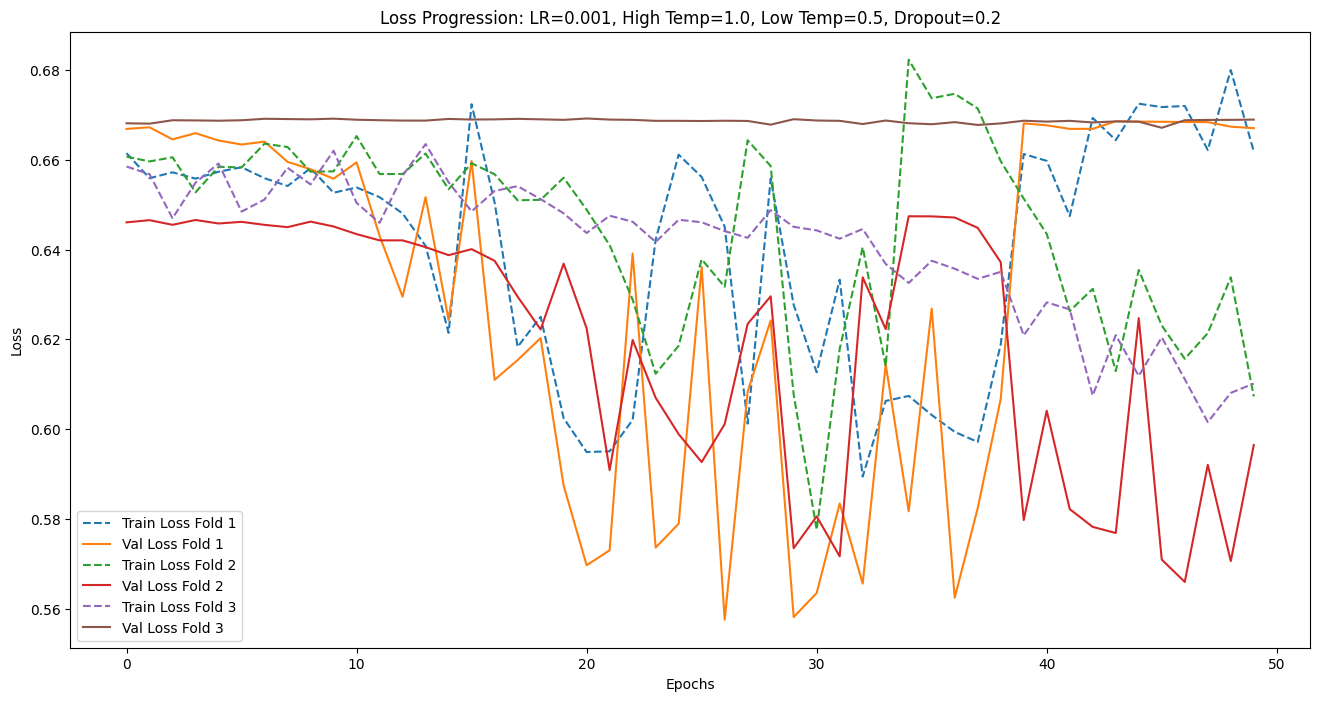

Testing params: LR=0.001, High Temp=1.0, Low Temp=0.5, Dropout=0.3
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:05<00:00,  8.79it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  8.64it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  9.26it/s]


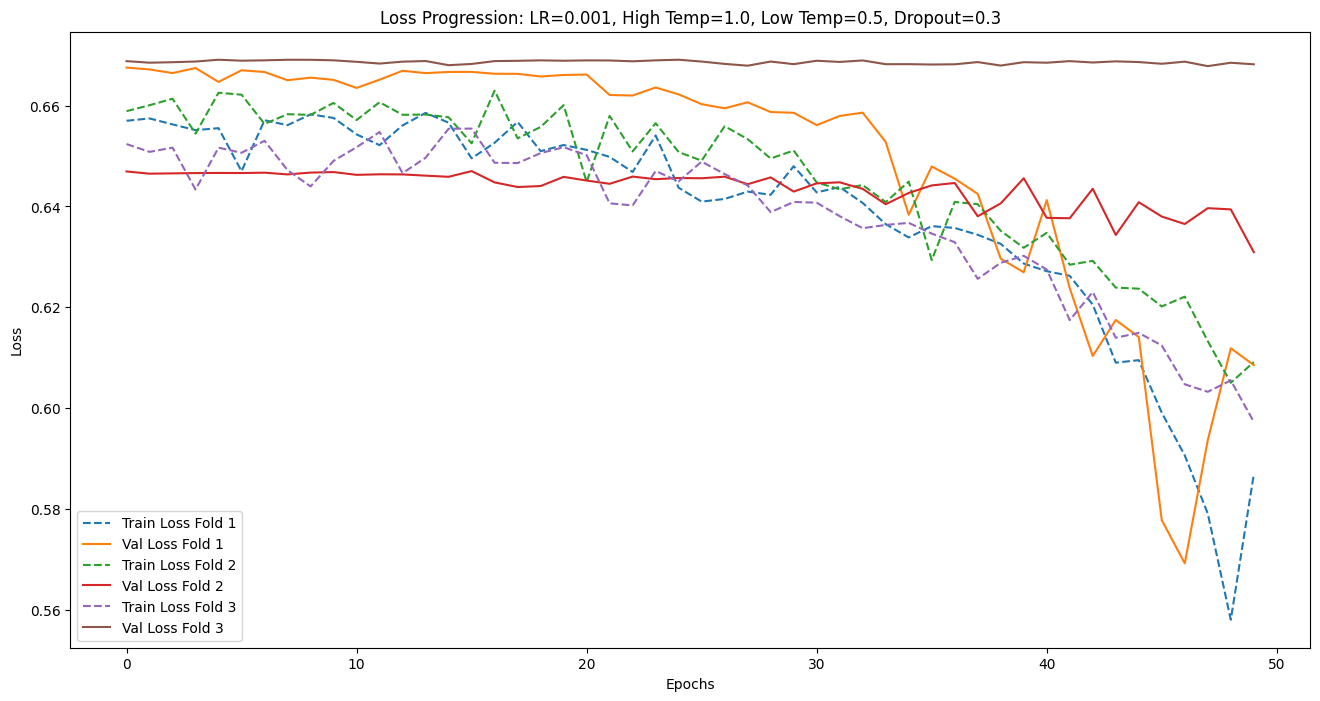

Testing params: LR=0.001, High Temp=0.9, Low Temp=0.3, Dropout=0.2
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:04<00:00, 10.06it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  8.72it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  9.68it/s]


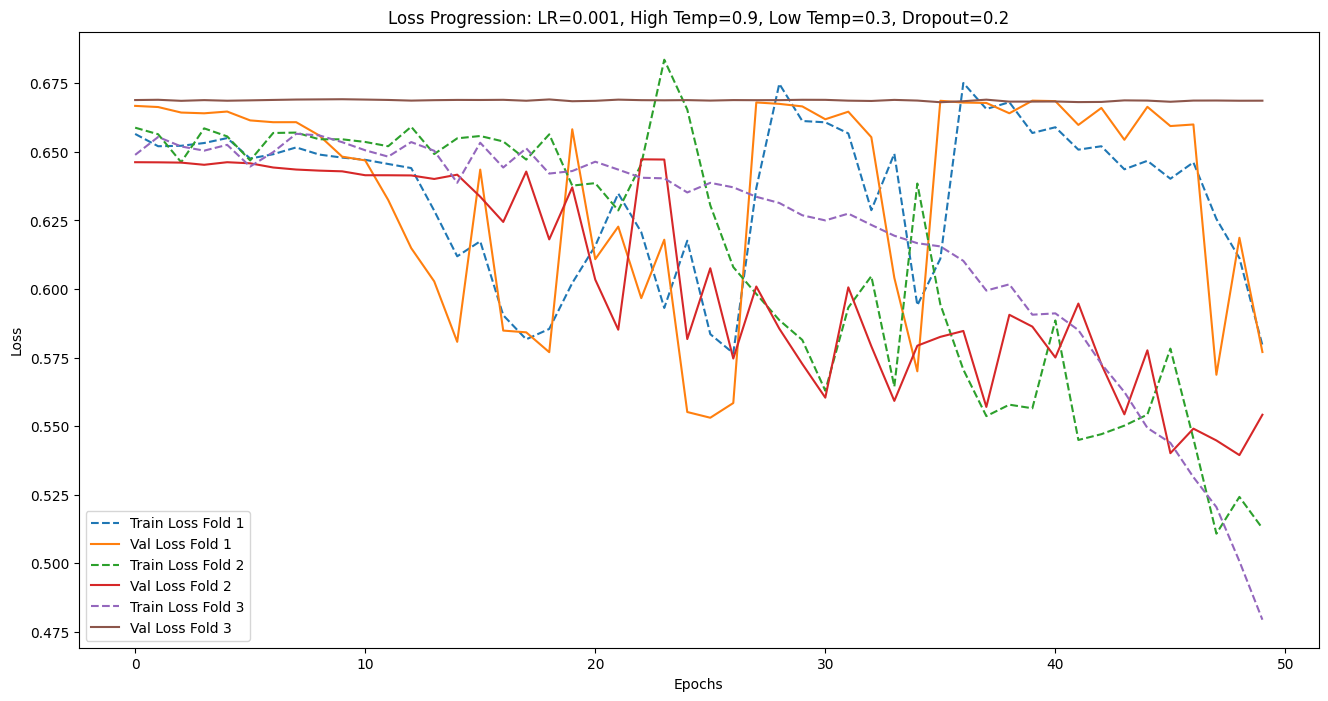

Testing params: LR=0.001, High Temp=0.9, Low Temp=0.3, Dropout=0.3
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:05<00:00,  9.76it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  8.46it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  9.75it/s]


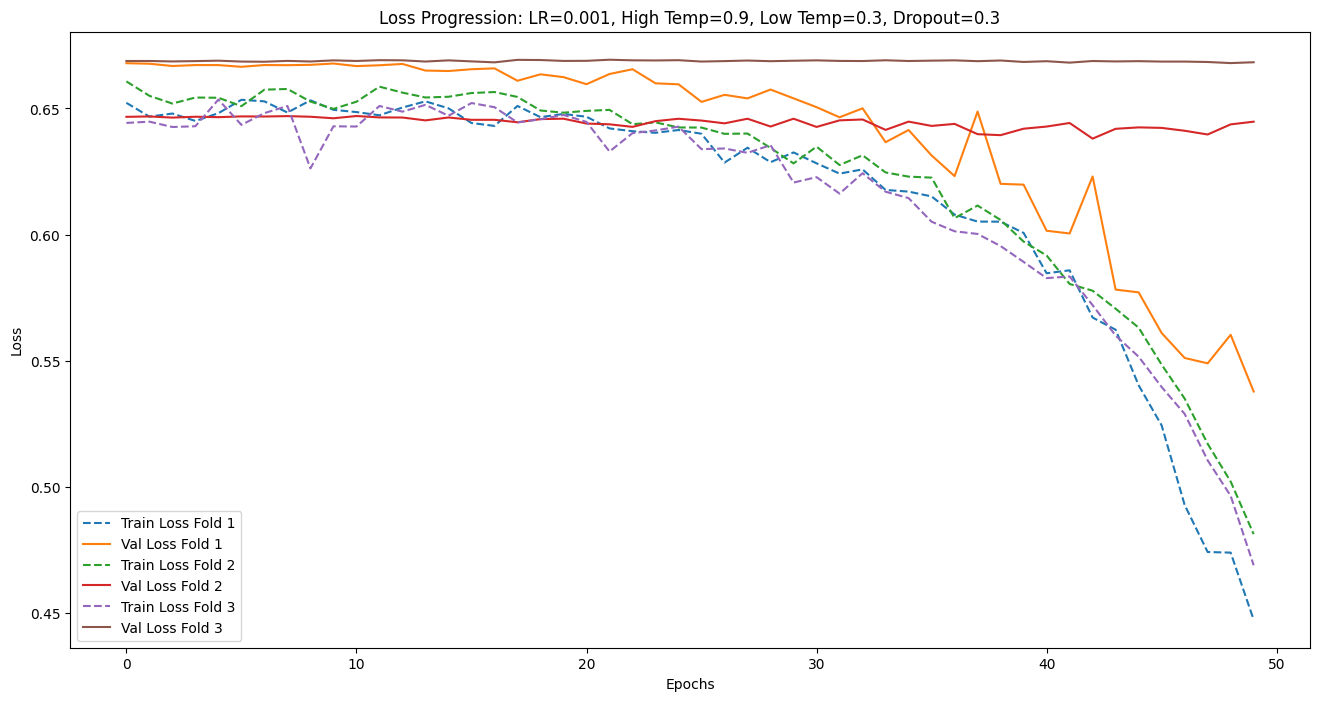

Testing params: LR=0.0005, High Temp=0.8, Low Temp=0.2, Dropout=0.2
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:04<00:00, 10.50it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:04<00:00, 10.17it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  9.95it/s]


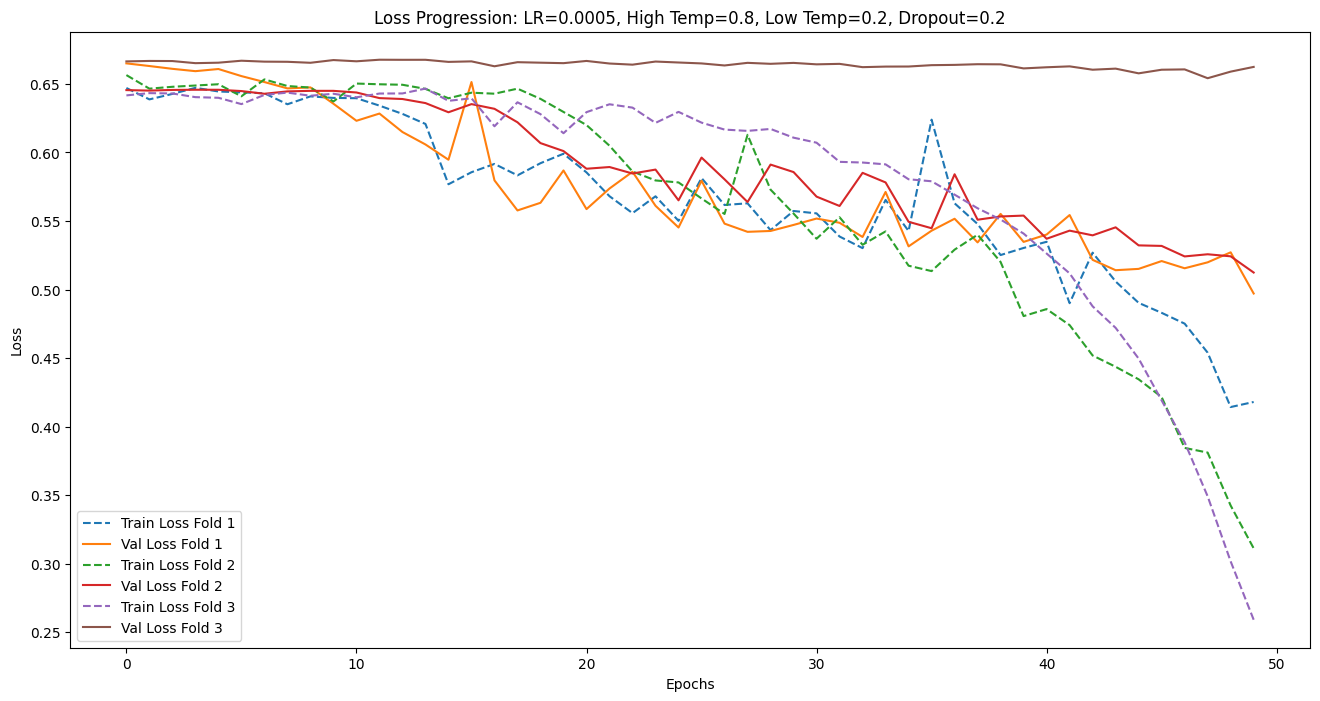

Testing params: LR=0.0005, High Temp=0.8, Low Temp=0.2, Dropout=0.3
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:04<00:00, 10.81it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:04<00:00, 10.07it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:04<00:00, 10.02it/s]


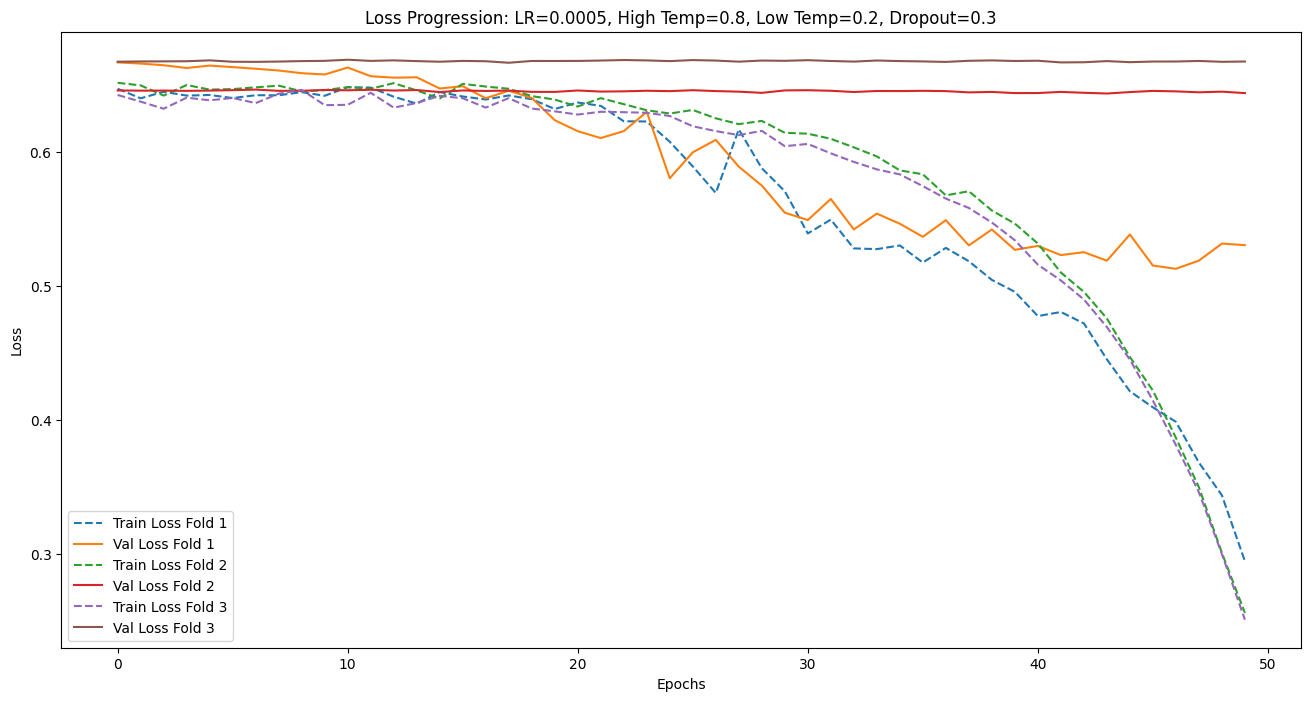

Testing params: LR=0.0005, High Temp=1.0, Low Temp=0.5, Dropout=0.2
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:04<00:00, 10.02it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  9.69it/s]


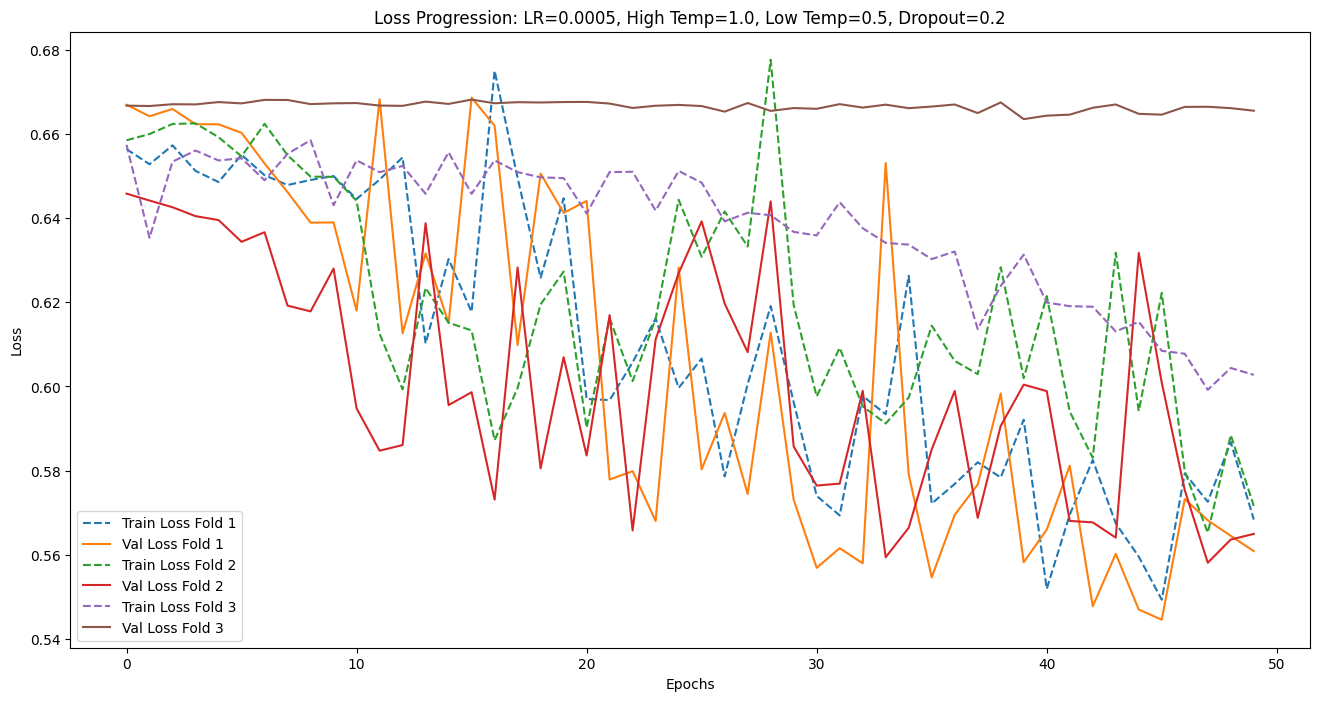

Testing params: LR=0.0005, High Temp=1.0, Low Temp=0.5, Dropout=0.3
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:05<00:00,  8.48it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  8.58it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  8.55it/s]


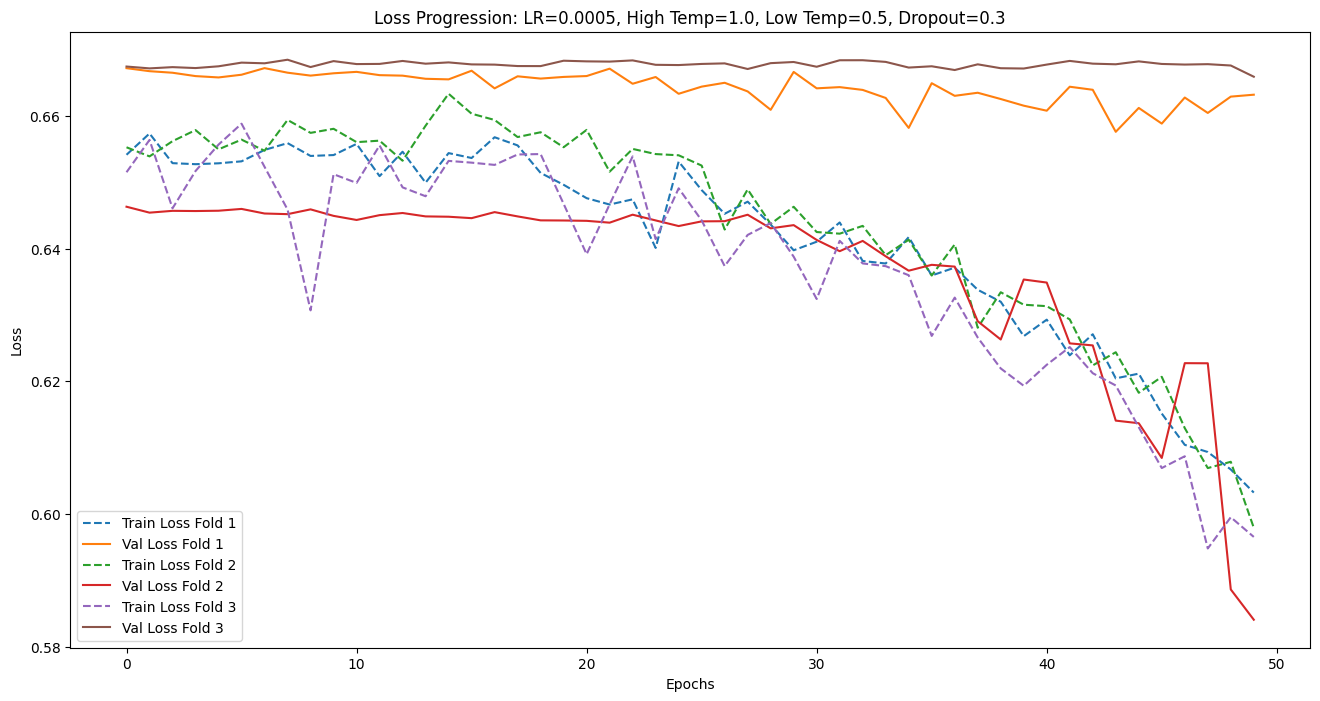

Testing params: LR=0.0005, High Temp=0.9, Low Temp=0.3, Dropout=0.2
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:05<00:00,  9.86it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  8.35it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


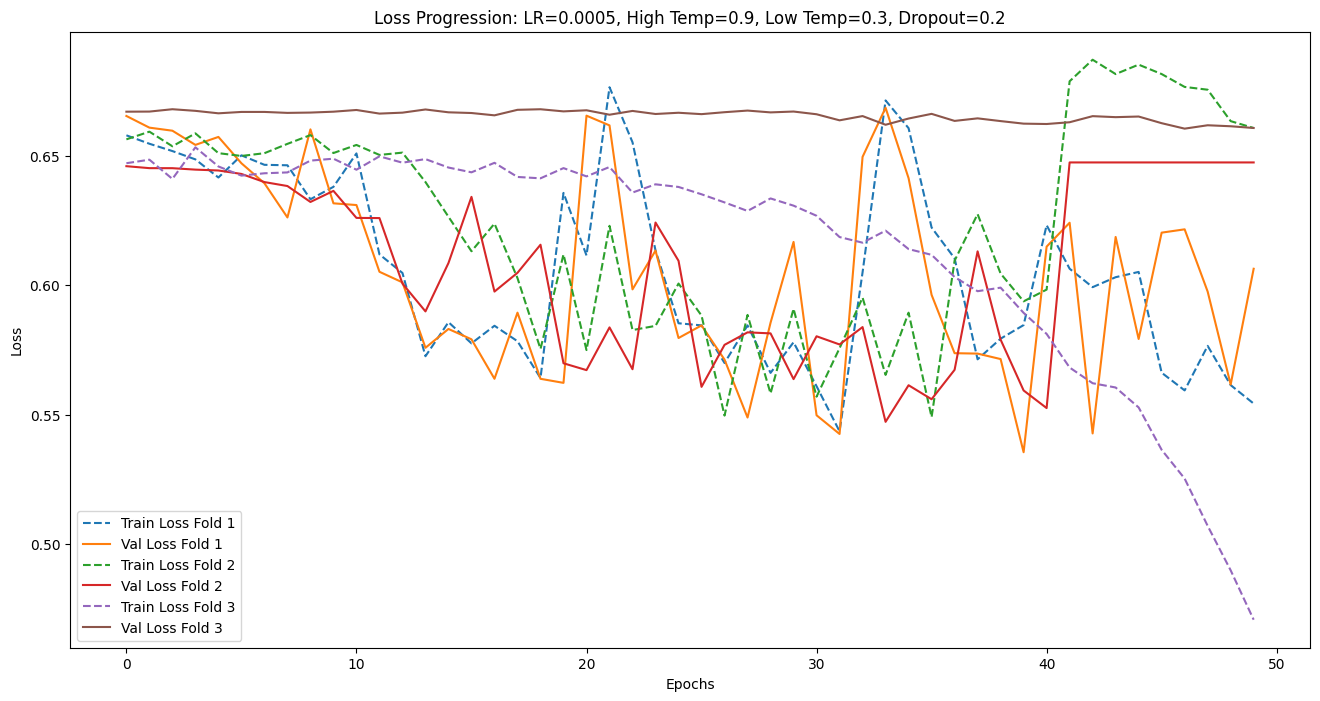

Testing params: LR=0.0005, High Temp=0.9, Low Temp=0.3, Dropout=0.3
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:04<00:00, 10.34it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  9.69it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  9.59it/s]


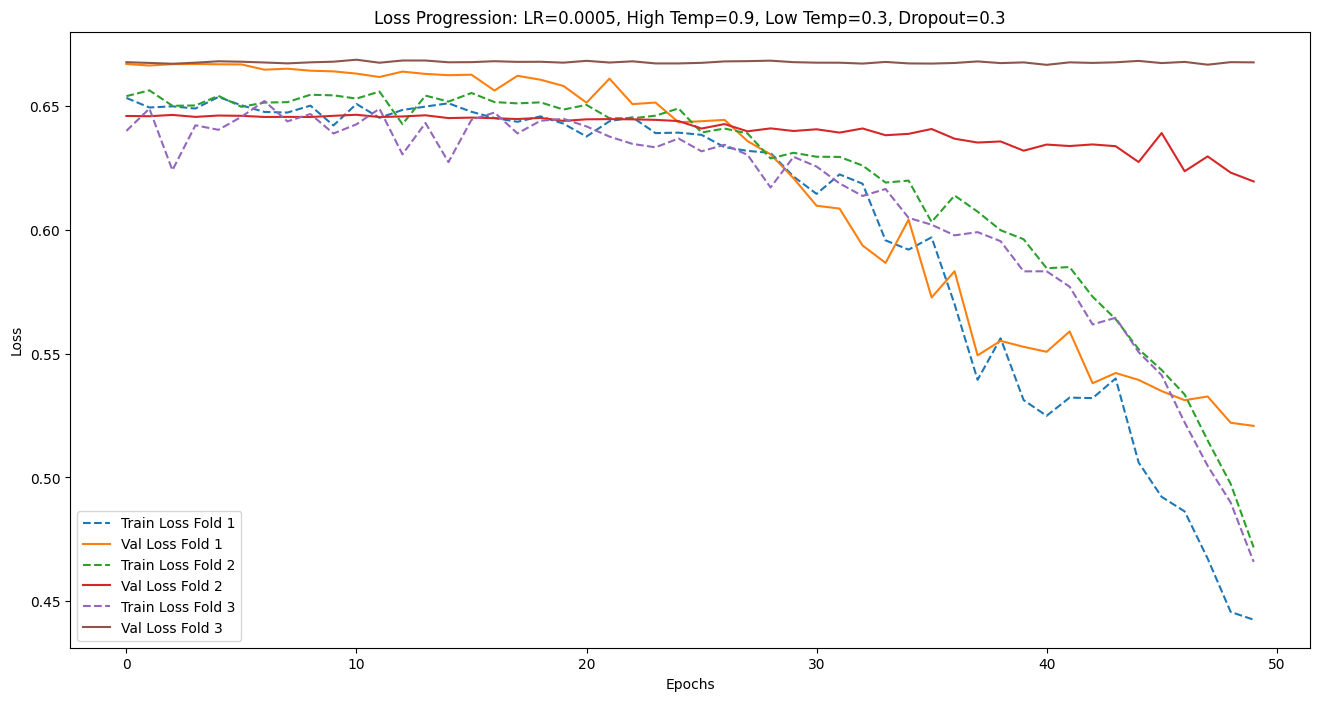

Testing params: LR=0.0001, High Temp=0.8, Low Temp=0.2, Dropout=0.2
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:04<00:00, 10.50it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  9.51it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  9.48it/s]


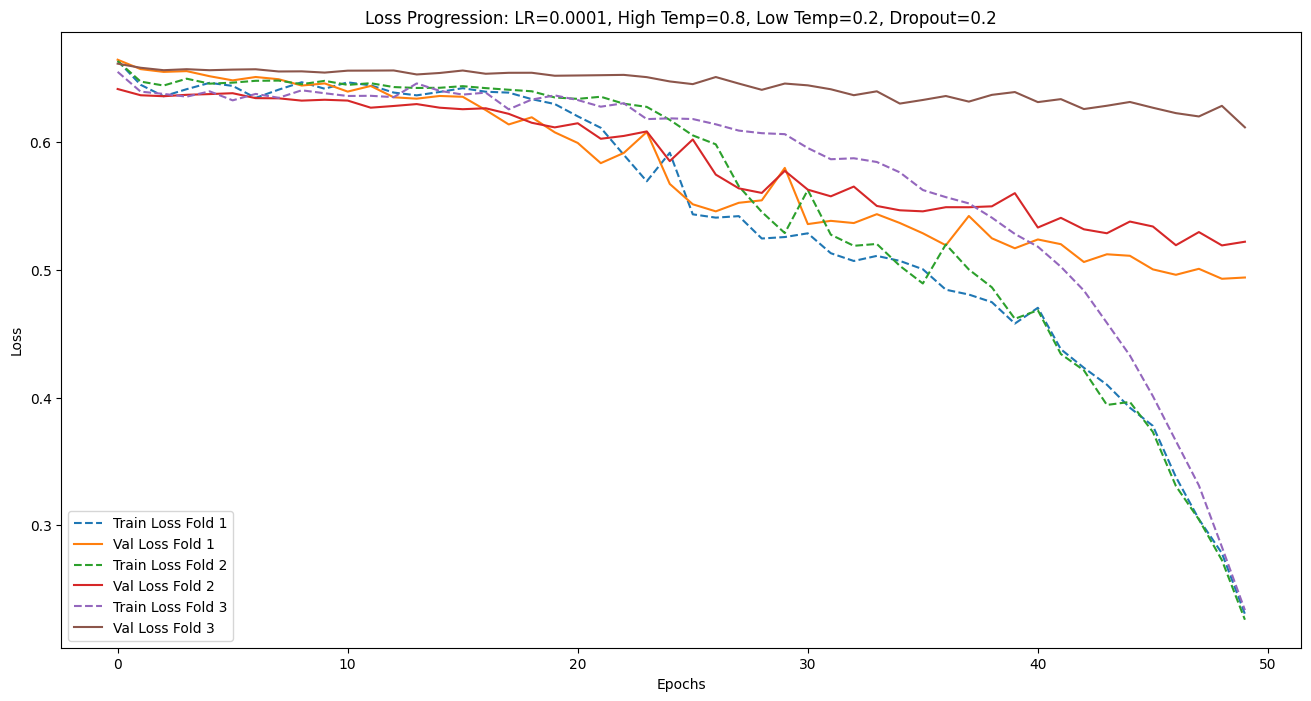

Testing params: LR=0.0001, High Temp=0.8, Low Temp=0.2, Dropout=0.3
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:04<00:00, 10.34it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  9.51it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  9.40it/s]


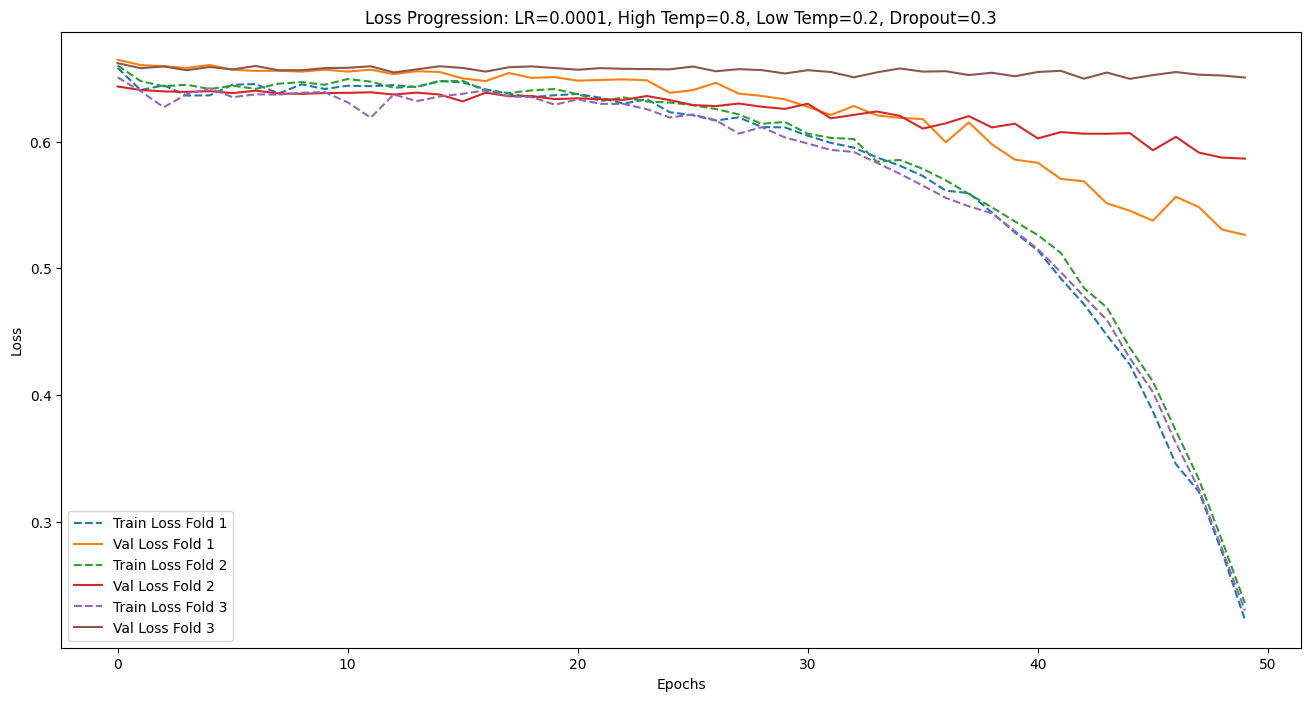

Testing params: LR=0.0001, High Temp=1.0, Low Temp=0.5, Dropout=0.2
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:04<00:00, 10.34it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  9.48it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  9.40it/s]


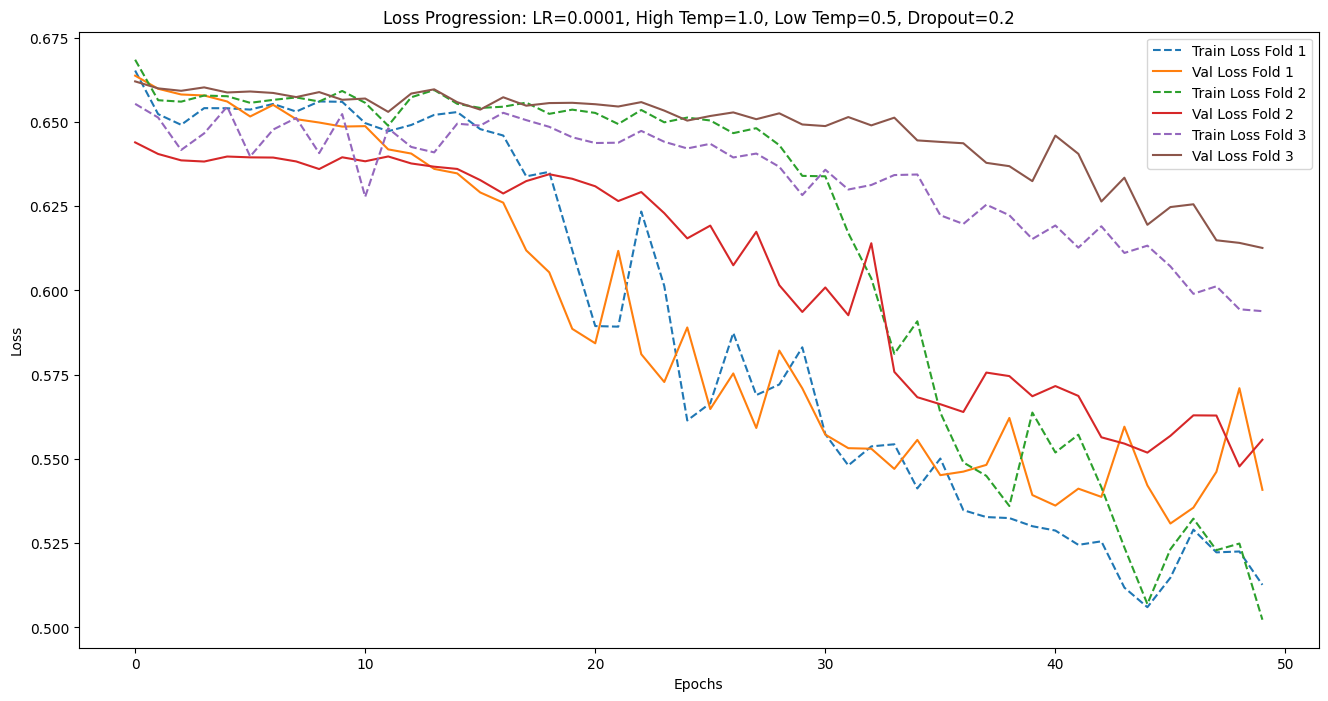

Testing params: LR=0.0001, High Temp=1.0, Low Temp=0.5, Dropout=0.3
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:05<00:00,  9.26it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  8.76it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:06<00:00,  7.91it/s]


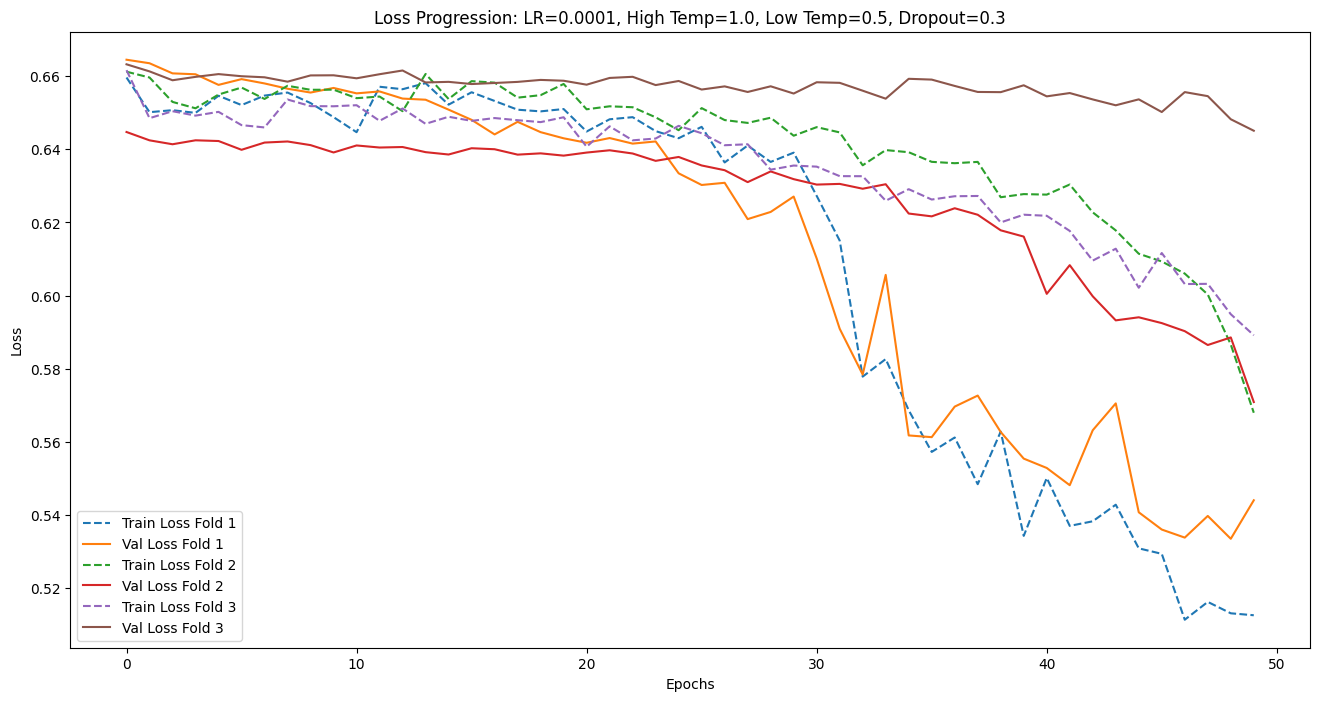

Testing params: LR=0.0001, High Temp=0.9, Low Temp=0.3, Dropout=0.2
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:05<00:00,  9.12it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:06<00:00,  8.06it/s]


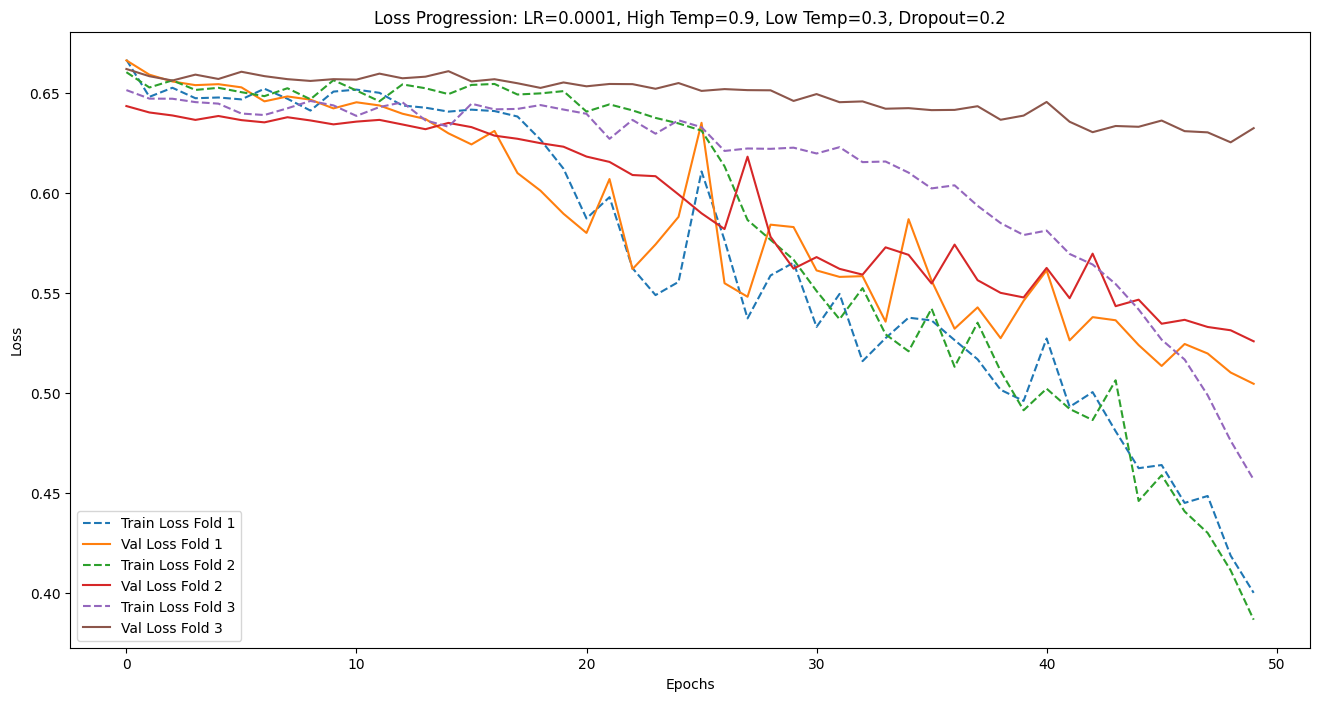

Testing params: LR=0.0001, High Temp=0.9, Low Temp=0.3, Dropout=0.3
Fold 1/3


Training Epochs (Fold 1): 100%|██████████| 50/50 [00:05<00:00,  8.97it/s]


Fold 2/3


Training Epochs (Fold 2): 100%|██████████| 50/50 [00:05<00:00,  8.61it/s]


Fold 3/3


Training Epochs (Fold 3): 100%|██████████| 50/50 [00:05<00:00,  8.55it/s]


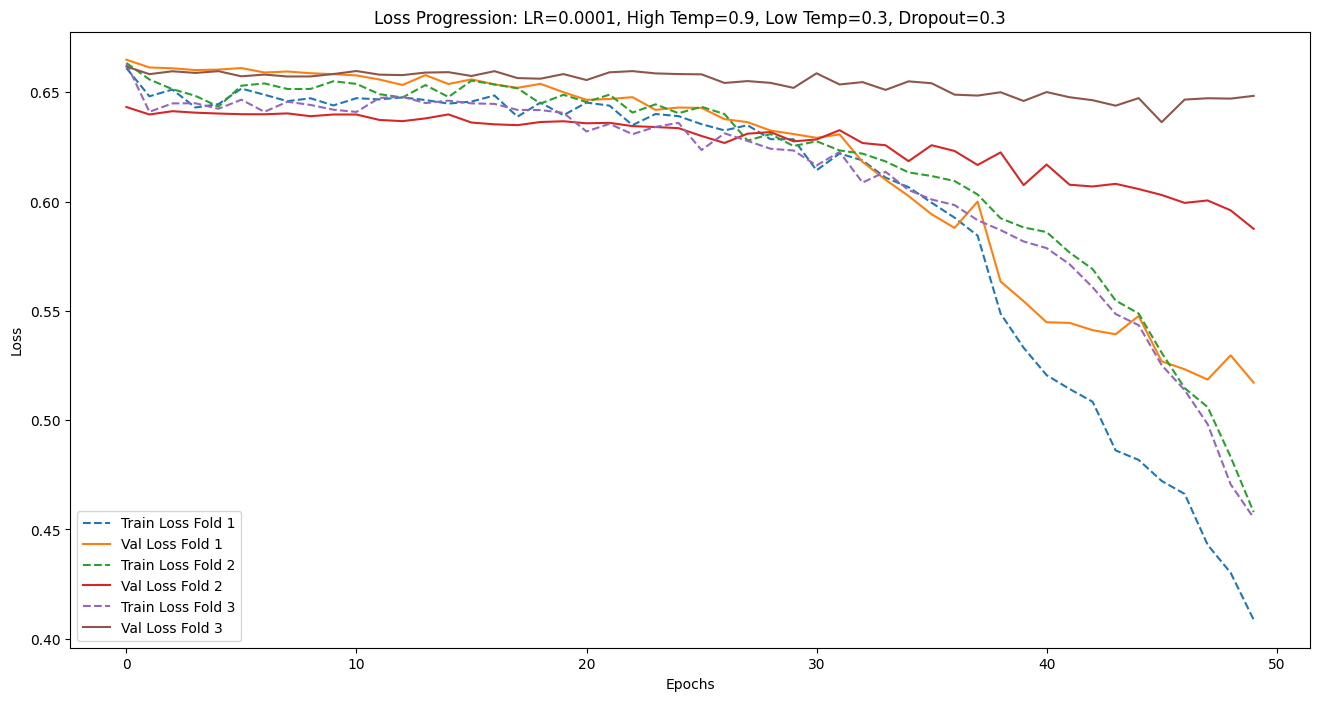

Params: (0.001, (0.8, 0.2), 0.2), Avg Val Loss: 0.5639
Params: (0.001, (0.8, 0.2), 0.3), Avg Val Loss: 0.6389
Params: (0.001, (1.0, 0.5), 0.2), Avg Val Loss: 0.5969
Params: (0.001, (1.0, 0.5), 0.3), Avg Val Loss: 0.6227
Params: (0.001, (0.9, 0.3), 0.2), Avg Val Loss: 0.5869
Params: (0.001, (0.9, 0.3), 0.3), Avg Val Loss: 0.6146
Params: (0.0005, (0.8, 0.2), 0.2), Avg Val Loss: 0.5546
Params: (0.0005, (0.8, 0.2), 0.3), Avg Val Loss: 0.6074
Params: (0.0005, (1.0, 0.5), 0.2), Avg Val Loss: 0.5888
Params: (0.0005, (1.0, 0.5), 0.3), Avg Val Loss: 0.6359
Params: (0.0005, (0.9, 0.3), 0.2), Avg Val Loss: 0.5811
Params: (0.0005, (0.9, 0.3), 0.3), Avg Val Loss: 0.6023
Params: (0.0001, (0.8, 0.2), 0.2), Avg Val Loss: 0.5412
Params: (0.0001, (0.8, 0.2), 0.3), Avg Val Loss: 0.5875
Params: (0.0001, (1.0, 0.5), 0.2), Avg Val Loss: 0.5638
Params: (0.0001, (1.0, 0.5), 0.3), Avg Val Loss: 0.5832
Params: (0.0001, (0.9, 0.3), 0.2), Avg Val Loss: 0.5519
Params: (0.0001, (0.9, 0.3), 0.3), Avg Val Loss: 0.580

In [190]:
from itertools import product
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import numpy as np
import torch.optim as optim
from tqdm import tqdm

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Hyperparameter grid
learning_rates = [1e-3, 5e-4, 1e-4]
temperature_ranges = [(0.8, 0.2), (1.0, 0.5), (0.9, 0.3)]
dropout_values = [0.2, 0.3]

# Generate all combinations of hyperparameters
param_grid = list(product(learning_rates, temperature_ranges, dropout_values))

# Cross-validation parameters
k_folds = 3
kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

# Results storage
grid_results = []

batch_size = 64
unique_game_ids = merged_df['GameID'].unique()
total_epochs = 50

for params in param_grid:
    lr, (high_temp, low_temp), dropout = params
    print(f"Testing params: LR={lr}, High Temp={high_temp}, Low Temp={low_temp}, Dropout={dropout}")

    fold_results = []

    # Initialize fold plots
    fold_train_losses = []
    fold_val_losses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(unique_game_ids)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Split games
        train_game_ids = unique_game_ids[train_idx]
        val_game_ids = unique_game_ids[val_idx]

        # Create datasets and dataloaders
        train_df = merged_df[merged_df['GameID'].isin(train_game_ids)].reset_index(drop=True)
        val_df = merged_df[merged_df['GameID'].isin(val_game_ids)].reset_index(drop=True)
        train_dataset = EmbeddingDataset(train_df)
        val_dataset = EmbeddingDataset(val_df)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, loss function, and optimizer
        projection_head_model = ProjectionHead(input_dim=768, hidden_dim=512, output_dim=256, dropout_p=dropout).to(device)
        contrastive_loss_function = SupervisedContrastiveLoss(high_temperature=high_temp, low_temperature=low_temp, total_epochs=50)
        optimizer = optim.Adam(projection_head_model.parameters(), lr=lr, weight_decay=1e-5)

        # Training loop
        total_epochs = 50
        best_val_loss = float('inf')
        train_losses = []
        val_losses = []

        for current_epoch in tqdm(range(total_epochs), desc=f"Training Epochs (Fold {fold + 1})"):
            contrastive_loss_function.set_epoch(current_epoch)
            projection_head_model.train()
            total_train_loss = 0

            # Train
            for batch_embeddings, batch_labels in train_dataloader:
                batch_embeddings = batch_embeddings.to(device)
                batch_labels = batch_labels.to(device)

                projected_embeddings = projection_head_model(batch_embeddings)
                batch_loss = contrastive_loss_function(projected_embeddings, batch_labels)

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

                total_train_loss += batch_loss.item()

            # Validate
            projection_head_model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for batch_embeddings, batch_labels in val_dataloader:
                    batch_embeddings = batch_embeddings.to(device)
                    batch_labels = batch_labels.to(device)

                    projected_embeddings = projection_head_model(batch_embeddings)
                    batch_loss = contrastive_loss_function(projected_embeddings, batch_labels)

                    total_val_loss += batch_loss.item()

            # Store losses
            avg_train_loss = total_train_loss / len(train_dataloader)
            avg_val_loss = total_val_loss / len(val_dataloader)
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            # Update best validation loss
            best_val_loss = min(best_val_loss, avg_val_loss)

        # Append fold results
        fold_results.append(best_val_loss)
        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)

    # Average validation loss across folds
    avg_val_loss_across_folds = np.mean(fold_results)
    grid_results.append((params, avg_val_loss_across_folds))

    # Plot training and validation loss for all folds
    plt.figure(figsize=(16, 8))
    for fold_idx, (train_loss, val_loss) in enumerate(zip(fold_train_losses, fold_val_losses)):
        plt.plot(train_loss, label=f"Train Loss Fold {fold_idx + 1}", linestyle='--')
        plt.plot(val_loss, label=f"Val Loss Fold {fold_idx + 1}")
    plt.title(f"Loss Progression: LR={lr}, High Temp={high_temp}, Low Temp={low_temp}, Dropout={dropout}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Print results for all hyperparameters
for params, val_loss in grid_results:
    print(f"Params: {params}, Avg Val Loss: {val_loss:.4f}")

# Find the best hyperparameter combination
best_params, best_val_loss = min(grid_results, key=lambda x: x[1])
print(f"Best Hyperparameters: {best_params}, Best Avg Val Loss: {best_val_loss:.4f}")

So we fix lr 0.0001 max min temp range 0.8,0.2 and dropout rate to be 0.2.

After playing a bit actually a max temp of 1 seems even better (visually)

In [210]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

best_lr = 1e-4  
best_high_temp = 1.0  
best_low_temp = 0.2  
best_dropout = 0.2 

full_dataset = EmbeddingDataset(merged_df)
full_dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

projection_head_model = ProjectionHead(
    input_dim=768,
    hidden_dim=512,
    output_dim=256,
    dropout_p=best_dropout,
).to(device)
contrastive_loss_function = SupervisedContrastiveLoss(
    high_temperature=best_high_temp,
    low_temperature=best_low_temp,
    total_epochs=50
)
optimizer = optim.Adam(projection_head_model.parameters(), lr=best_lr, weight_decay=1e-5)

total_epochs = 50
train_losses = []

for current_epoch in range(total_epochs):
    contrastive_loss_function.set_epoch(current_epoch)
    projection_head_model.train()
    total_train_loss = 0

    for batch_embeddings, batch_labels in full_dataloader:
        batch_embeddings = batch_embeddings.to(device)
        batch_labels = batch_labels.to(device)

        projected_embeddings = projection_head_model(batch_embeddings)
        batch_loss = contrastive_loss_function(projected_embeddings, batch_labels)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        total_train_loss += batch_loss.item()

    avg_train_loss = total_train_loss / len(full_dataloader)
    train_losses.append(avg_train_loss)

    print(f"Epoch [{current_epoch + 1}/{total_epochs}], Train Loss: {avg_train_loss:.4f}, "
          f"Temperature: {contrastive_loss_function.get_temperature():.4f}")


Epoch [1/50], Train Loss: 0.6639, Temperature: 1.0000
Epoch [2/50], Train Loss: 0.6591, Temperature: 1.0000
Epoch [3/50], Train Loss: 0.6596, Temperature: 1.0000
Epoch [4/50], Train Loss: 0.6593, Temperature: 1.0000
Epoch [5/50], Train Loss: 0.6550, Temperature: 1.0000
Epoch [6/50], Train Loss: 0.6518, Temperature: 1.0000
Epoch [7/50], Train Loss: 0.6582, Temperature: 1.0000
Epoch [8/50], Train Loss: 0.6583, Temperature: 1.0000
Epoch [9/50], Train Loss: 0.6537, Temperature: 1.0000
Epoch [10/50], Train Loss: 0.6565, Temperature: 1.0000
Epoch [11/50], Train Loss: 0.6546, Temperature: 1.0000
Epoch [12/50], Train Loss: 0.6517, Temperature: 1.0000
Epoch [13/50], Train Loss: 0.6547, Temperature: 1.0000
Epoch [14/50], Train Loss: 0.6430, Temperature: 1.0000
Epoch [15/50], Train Loss: 0.6176, Temperature: 1.0000
Epoch [16/50], Train Loss: 0.6174, Temperature: 1.0000
Epoch [17/50], Train Loss: 0.5940, Temperature: 0.9771
Epoch [18/50], Train Loss: 0.6128, Temperature: 0.9543
Epoch [19/50], Trai

In [211]:
projection_head_model.eval()
projections = []
with torch.no_grad():  
    for embedding in merged_df["aggregated_embedding"]:
        embedding_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 768)
        projection = projection_head_model(embedding_tensor)  
        projections.append(projection.cpu().numpy().flatten())

merged_df = merged_df.copy()
merged_df["projections"] = projections
X = np.vstack(merged_df["projections"].values)
y = merged_df["EventType"].values

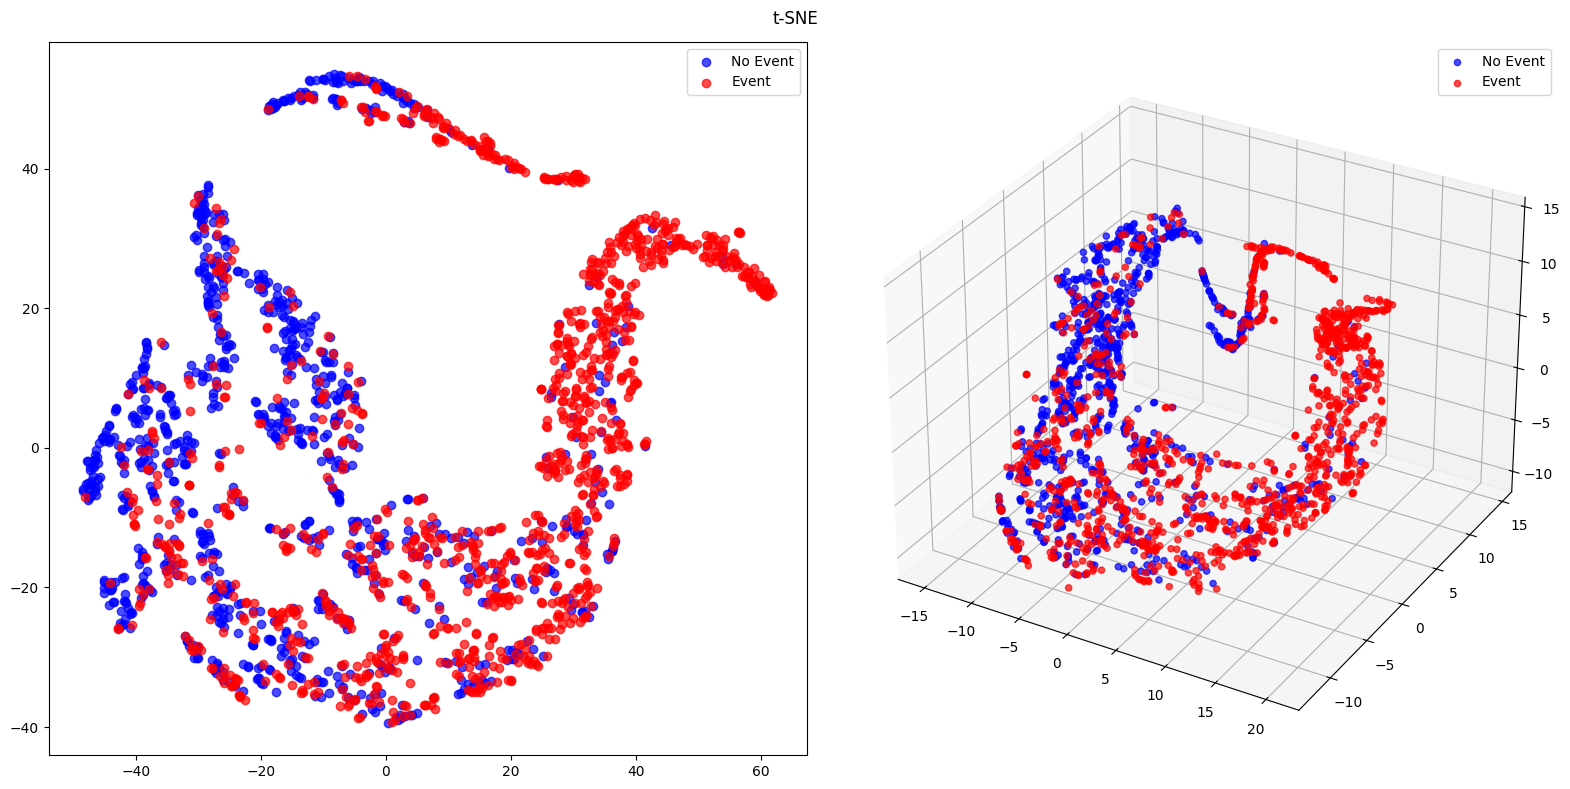

In [212]:
tsne2d = TSNE(n_components=2, random_state=seed)
reduced_embeddings2d = tsne2d.fit_transform(X)
tsne3d = TSNE(n_components=3, random_state=seed)
reduced_embeddings3d = tsne3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("t-SNE")
plt.tight_layout()
plt.show()

c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\sandr\anaconda3\envs\mldl-ecole\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


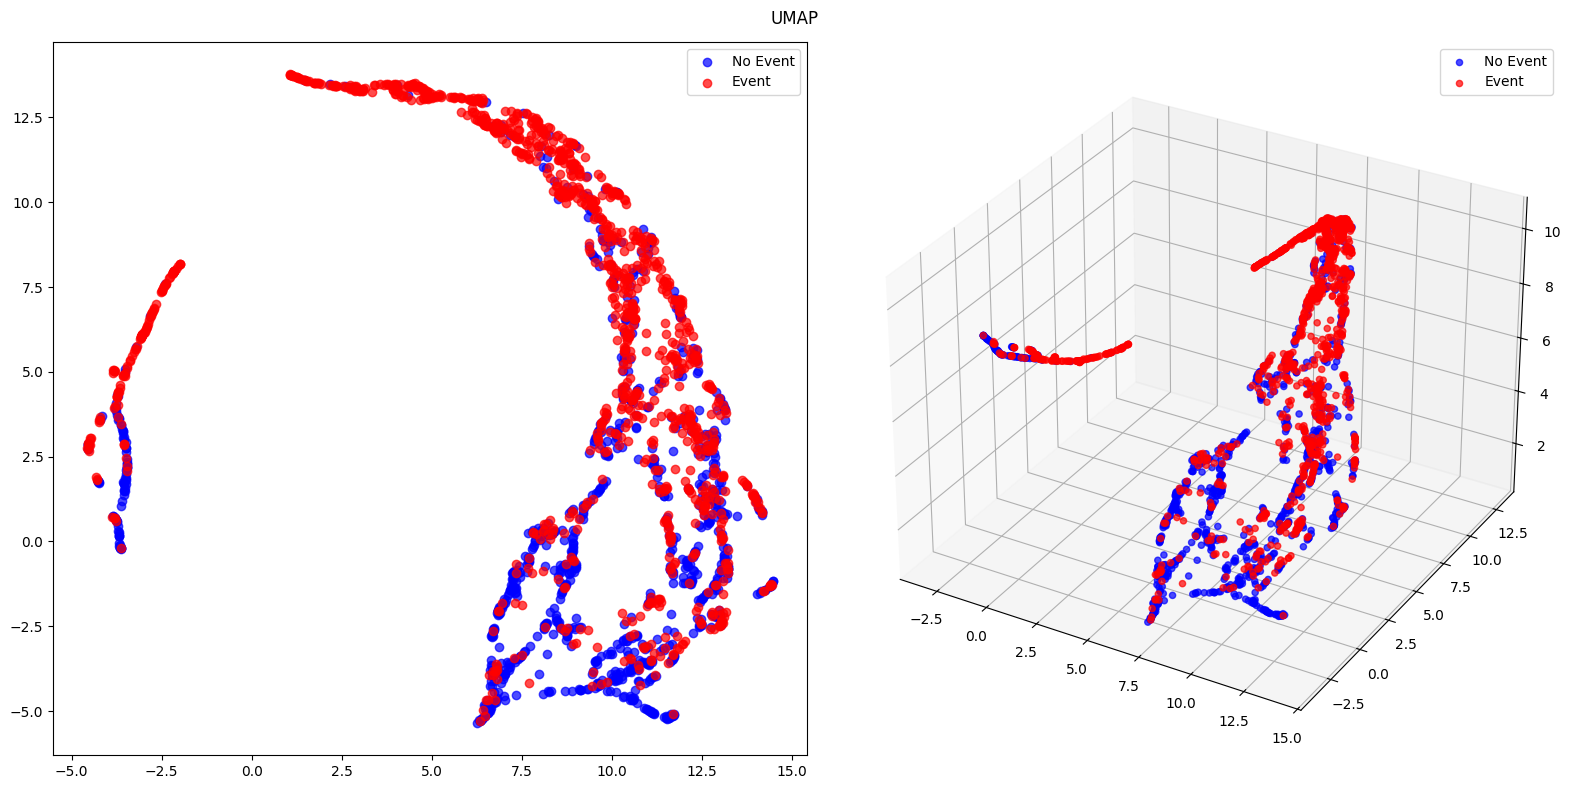

In [213]:
umap2d = umap.UMAP(n_components=2, random_state=seed)
reduced_embeddings2d = umap2d.fit_transform(X)
umap3d = umap.UMAP(n_components=3, random_state=seed)
reduced_embeddings3d = umap3d.fit_transform(X)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax1.scatter(
        reduced_embeddings2d[mask, 0],
        reduced_embeddings2d[mask, 1],
        c=color,
        label=label,
        alpha=0.7
    )
ax1.legend()
ax2 = fig.add_subplot(122, projection='3d')
for event_type, color, label in zip([0, 1], ['blue', 'red'], ['No Event', 'Event']):
    mask = (y == event_type)
    ax2.scatter(
        reduced_embeddings3d[mask, 0],
        reduced_embeddings3d[mask, 1],
        reduced_embeddings3d[mask, 2],
        c=color,
        label=label,
        alpha=0.7
    )
ax2.legend()
plt.suptitle("UMAP")
plt.tight_layout()
plt.show()

In [214]:
torch.save(projection_head_model.state_dict(), "models/contrastive_projection_model.pth")
print("Model trained and saved.")

Model trained and saved.


In [215]:
merged_df

ID                               aggregated_embedding  EventType  \
0       0_0  [0.113863185, 0.25399217, 0.16831651, -0.08117...          0   
1       0_1  [0.120237485, 0.2669787, 0.16120772, -0.075147...          0   
2      0_10  [0.07998199, 0.26179686, 0.1610382, -0.0552430...          1   
3     0_100  [0.09074174, 0.26145023, 0.14973955, -0.044975...          1   
4     0_101  [0.07723929, 0.26390603, 0.15838297, -0.050099...          1   
...     ...                                                ...        ...   
2132   8_95  [0.0442052, 0.25004005, 0.12509423, -0.0469851...          0   
2133   8_96  [0.045044363, 0.25035122, 0.1290281, -0.059350...          1   
2134   8_97  [0.05991027, 0.24008104, 0.13231327, -0.046415...          1   
2135   8_98  [0.03905512, 0.24726795, 0.11885731, -0.045002...          0   
2136   8_99  [0.045700755, 0.25223252, 0.13476954, -0.04659...          1   

      GameID                                        projections  
0          0  [0.014253048, -0.018236972, 0.010079978, 0.010...  
1          0  [0.012135299, -0.0152868815, 0.010129323, 0.00...  
2          0  [0.0025690515, -0.001289459, 0.00089222565, -0...  
3          0  [-0.024986934, 0.04065267, -0.022168677, -0.02...  
4          0  [-0.01950165, 0.034342688, -0.016194643, -0.01...  
...      ...                                                ...  
2132       8  [0.00089520775, -0.0037699267, 0.0030271895, -...  
2133       8  [0.0007042419, -0.0006733872, 0.0027319398, -0...  
2134       8  [0.00072189793, -0.0018619392, 0.001450846, -0...  
2135       8  [-0.0062117213, 0.010094658, -0.004626941, -0....  
2136       8  [-0.0061711036, 0.0069602504, -0.0010169614, -...  

[2137 rows x 5 columns]

In [219]:
merged_df = merged_df.drop(columns=['GameID', 'aggregated_embedding'])
merged_df = merged_df.rename(columns={'projections': 'aggregated_embedding'})

In [221]:
merged_df

ID  EventType                               aggregated_embedding
0       0_0          0  [0.014253048, -0.018236972, 0.010079978, 0.010...
1       0_1          0  [0.012135299, -0.0152868815, 0.010129323, 0.00...
2      0_10          1  [0.0025690515, -0.001289459, 0.00089222565, -0...
3     0_100          1  [-0.024986934, 0.04065267, -0.022168677, -0.02...
4     0_101          1  [-0.01950165, 0.034342688, -0.016194643, -0.01...
...     ...        ...                                                ...
2132   8_95          0  [0.00089520775, -0.0037699267, 0.0030271895, -...
2133   8_96          1  [0.0007042419, -0.0006733872, 0.0027319398, -0...
2134   8_97          1  [0.00072189793, -0.0018619392, 0.001450846, -0...
2135   8_98          0  [-0.0062117213, 0.010094658, -0.004626941, -0....
2136   8_99          1  [-0.0061711036, 0.0069602504, -0.0010169614, -...

[2137 rows x 3 columns]

In [222]:
merged_df.to_pickle("processed_data/contrastive_similarity_aggregated_processed2_no_teams_embeddings_with_labels.pkl")

## Test Set

In [224]:
file_path = "processed_data/similarity_aggregated_processed2_no_teams_embeddings_with_labels_test.pkl"
merged_df_test = pd.read_pickle(file_path)

In [225]:
projection_head_model.eval()
projections_test = []
with torch.no_grad():  
    for embedding in merged_df_test["aggregated_embedding"]:
        embedding_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).to(device)  # (1, 768)
        projection = projection_head_model(embedding_tensor)  
        projections_test.append(projection.cpu().numpy().flatten())

merged_df_test = merged_df_test.copy()
merged_df_test["projections"] = projections_test

In [226]:
merged_df_test

ID                               aggregated_embedding  MatchID  \
0      15_0  [0.035216145, 0.23670512, 0.16461788, -0.07351...       15   
1      15_1  [0.034069423, 0.23782559, 0.16553776, -0.07227...       15   
2     15_10  [0.03389384, 0.24631235, 0.15847614, -0.065858...       15   
3    15_100  [0.032782994, 0.25771907, 0.14000085, -0.06382...       15   
4    15_101  [0.022839505, 0.25066984, 0.14487386, -0.06689...       15   
..      ...                                                ...      ...   
511    9_95  [0.021239778, 0.2399597, 0.1421722, -0.0662935...        9   
512    9_96  [0.023016805, 0.2511774, 0.12957984, -0.068158...        9   
513    9_97  [0.02473588, 0.2408242, 0.13554707, -0.0646261...        9   
514    9_98  [0.02699592, 0.23885195, 0.13381645, -0.060118...        9   
515    9_99  [0.026203532, 0.2503568, 0.1359882, -0.0650007...        9   

                                           projections  
0    [0.0008742511, -0.0019406136, 0.0010033399, 0....  
1    [0.0004890263, -0.0015393868, 0.00087904744, 0...  
2    [0.0016751662, -0.0038999673, 0.0026903823, 0....  
3    [-0.003177479, 0.004805248, -0.0013133045, -0....  
4    [-0.0030589225, 0.00402534, -0.0009817984, -0....  
..                                                 ...  
511  [-0.0016087871, -0.00083546154, 0.00024853833,...  
512  [-0.0028160568, -0.00029376894, -0.00019351393...  
513  [-0.0027048253, 0.0016306136, -0.00034174696, ...  
514  [-0.003956547, 0.0048699416, -0.0017305091, -0...  
515  [-0.004848538, 0.004794577, -0.002428269, -0.0...  

[516 rows x 4 columns]

In [228]:
merged_df_test = merged_df_test.drop(columns=['MatchID', 'aggregated_embedding'])
merged_df_test = merged_df_test.rename(columns={'projections': 'aggregated_embedding'})

In [229]:
merged_df_test

ID                               aggregated_embedding
0      15_0  [0.0008742511, -0.0019406136, 0.0010033399, 0....
1      15_1  [0.0004890263, -0.0015393868, 0.00087904744, 0...
2     15_10  [0.0016751662, -0.0038999673, 0.0026903823, 0....
3    15_100  [-0.003177479, 0.004805248, -0.0013133045, -0....
4    15_101  [-0.0030589225, 0.00402534, -0.0009817984, -0....
..      ...                                                ...
511    9_95  [-0.0016087871, -0.00083546154, 0.00024853833,...
512    9_96  [-0.0028160568, -0.00029376894, -0.00019351393...
513    9_97  [-0.0027048253, 0.0016306136, -0.00034174696, ...
514    9_98  [-0.003956547, 0.0048699416, -0.0017305091, -0...
515    9_99  [-0.004848538, 0.004794577, -0.002428269, -0.0...

[516 rows x 2 columns]

In [230]:
merged_df_test.to_pickle("processed_data/contrastive_similarity_aggregated_processed2_no_teams_embeddings_with_labels_test.pkl")